In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
}))

source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [6]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [7]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [8]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

### Load guide df

In [9]:
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

gene     guide1      guide2      alias    subclass class     gene_or_rsid
1 CD13     CD13-1a     CD13-1b     ANPEP    tss      targeting ANPEP       
2 CD55     CD55-1a     CD55-1b     CD55     tss      targeting CD55        
3 CD73     CD73-1a     CD73-1b     NT5E     tss      targeting NT5E        
4 FUBP1    FUBP1-1a    FUBP1-1b    FUBP1    tss      targeting FUBP1       
5 C15orf40 C15orf40-1a C15orf40-1b C15orf40 tss      targeting C15orf40    
6 MAFF     MAFF-1a     MAFF-1b     MAFF     tss      targeting MAFF        
  label      
1 Control TSS
2 Control TSS
3 Control TSS
4 Control TSS
5 Control TSS
6 Control TSS

## FeaturePlot singlet & doublet

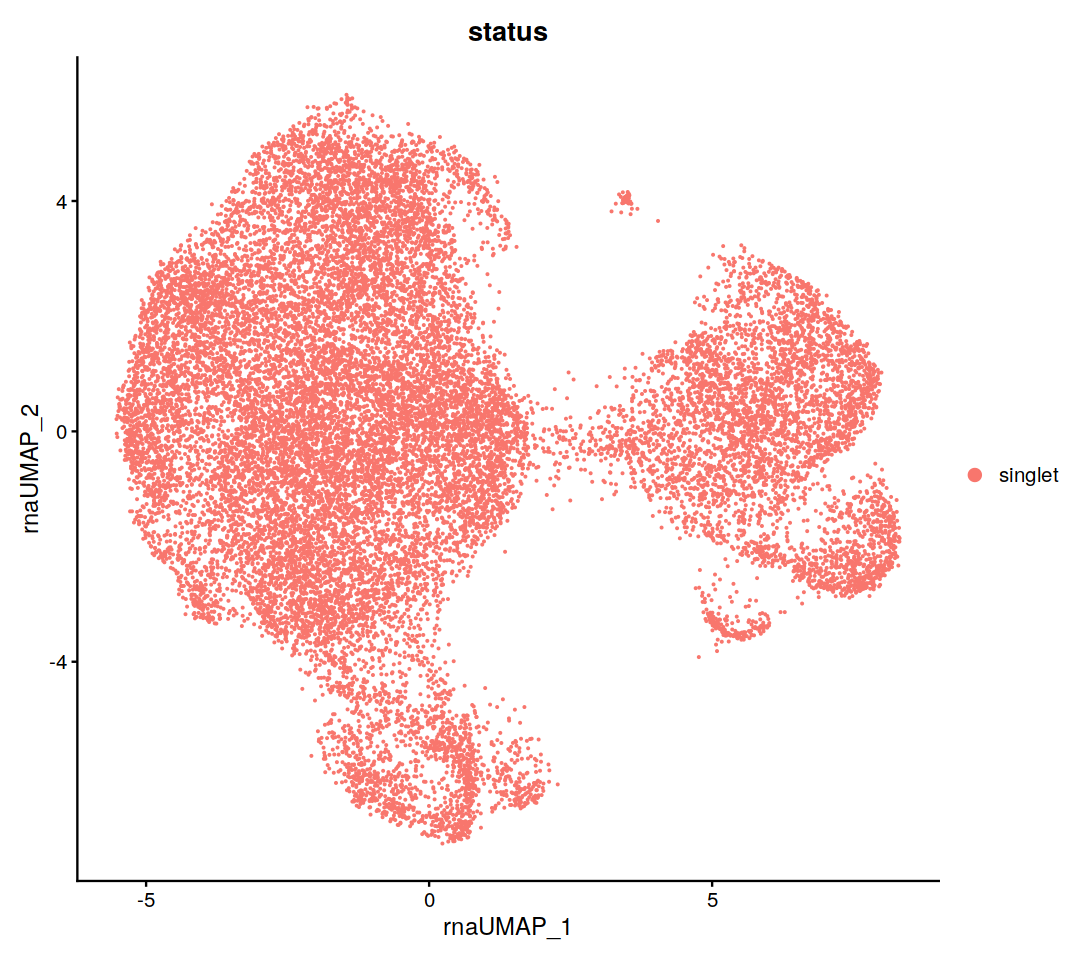

In [10]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(seurat_combined, group.by='status')

# Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries) {
        seurat_lib = seurat_libs[[lib]]
        threshold = df_thresholds[i, lib]
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

In [13]:
length(perturbed_cells_by_guide[[3]])

[1] 919

Find all unperturbed cells: these are the cells with either no guides or only NT guides

In [14]:
select_targeting_guides = df_guide$class == 'targeting'
df_targeting  = df_guide[select_targeting_guides, ]
targeting_guides = c(df_targeting$guide1, df_targeting$guide2)
seurat_rna <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, targeting_guides)
unperturbed_cells <- Cells(subset(seurat_rna, idents='target_negative'))

CD13-1a   1003 
CD55-1a   1834 
CD73-1a   2581 
FUBP1-1a   3216 
C15orf40-1a   3955 
MAFF-1a   4487 
FTH1-1a   4960 
FTH1-2a   7090 
PLIN3-1a   7645 
PLIN3-2a   8067 
TKT-1a   8435 
TKT-2a   8902 
LGALS3-1a   9391 
LGALS3-2a   9785 
CSTB-1a   10268 
CSTB-2a   10704 
CTSB-1a   11163 
CTSB-2a   11535 
KLF6-1a   11907 
KLF6-2a   12276 
DE1-1a   12584 
DE1-2a   12918 
DE2-1a   12918 
DE2-2a   13273 
DE3-1a   13621 
DE3-2a   13927 
DE4-1a   14412 
DE4-2a   14635 
DE5-1a   14925 
DE5-2a   15229 
DE6-1a   15469 
DE6-2a   15978 
DE7-1a   16239 
DE7-2a   16439 
DE8-1a   16675 
DE8-2a   16906 
DE9-1a   17126 
DE9-2a   17126 
DE10-1a   17274 
DE10-2a   17457 
DE11-1a   17655 
DE11-2a   17832 
DE12-1a   17983 
DE12-2a   18117 
DE13-1a   18283 
DE13-2a   18409 
DE14-1a   18559 
DE14-2a   18715 
DE15-1a   18865 
DE15-2a   19032 
DE16-1a   19156 
DE16-2a   19156 
DE17-1a   19272 
DE17-2a   19395 
CD13-1b   19407 
CD55-1b   19421 
CD73-1b   19432 
FUBP1-1b   19445 
C15orf40-1b   19458 
MAFF-1b   19467

# Split by donor, then run DE testing 

In [15]:
count_idents <- function(seurat_obj, idents) {
    length(Cells(subset(seurat_obj, idents = idents)))
}

In [16]:
targets = unique(filter(df_guide, class=='targeting')$alias)
df_de = NULL
genes_to_skip = c("CD55", "CSTB", "DE11")
genes_to_skip = c()
donors = sort(unique(seurat_rna$donor))
lfc_threshold = 0.15

for(donor_id in donors){
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, df_thresholds, donor_id)
    
    cat(green("Running Donor#", donor_id, "\n"))
    for(target in targets){
        if(target %in% genes_to_skip){
            cat(red("Skipping", target, "\n"))
            next
        }
        guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
        cat(blue(target,":"), paste(guides_4_target, collapse=","),"\n")
        seurat_dummy <- mark_target_pos_neg(seurat_donor, perturbed_cells_by_guide, guides_4_target, print_counts = T)
        
        markers <- FindMarkers(
            object = seurat_dummy,
            slot = "data",
            ident.1 = 'target_positive',
            ident.2 = 'target_negative',
            test.use = "MAST",
            latent.vars = c("library"),
            logfc.threshold = lfc_threshold,
            verbose = FALSE
        )
        # latent.vars = c('library') 
        if(nrow(markers)==0) {
            cat(Red("No DE genes", target,  "\n"))
        }
        markers$de_gene = rownames(markers)
        markers$target  = target
        markers$donor   = donor_id
        rownames(markers) <- NULL
        df_de = rbind(df_de, markers)
    }
}

Running Donor# 0 
ANPEP : CD13-1a,CD13-1b 
CD13-1a   245 
CD13-1b   334 
Guide+ = 334 ; Guide- = 5405 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

CD55 : CD55-1a,CD55-1b 
CD55-1a   265 
CD55-1b   348 
Guide+ = 348 ; Guide- = 5391 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>-----------

NT5E : CD73-1a,CD73-1b 
CD73-1a   221 
CD73-1b   302 
Guide+ = 302 ; Guide- = 5437 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>-----------------

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   204 
FUBP1-1b   272 
Guide+ = 272 ; Guide- = 5467 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>-------------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   245 
C15orf40-1b   325 
Guide+ = 325 ; Guide- = 5414 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>--------------------

MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   211 
MAFF-1b   266 
Guide+ = 266 ; Guide- = 5473 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>--------------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
FTH1-1a   163 
FTH1-2a   945 
FTH1-1b   1000 
FTH1-2b   1000 
Guide+ = 1000 ; Guide- = 4739 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>--------------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
PLIN3-1a   242 
PLIN3-2a   463 
PLIN3-1b   542 
PLIN3-2b   608 
Guide+ = 608 ; Guide- = 5131 



 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [======================>----

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
TKT-1a   189 
TKT-2a   436 
TKT-1b   493 
TKT-2b   575 
Guide+ = 575 ; Guide- = 5164 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [=====================>-----

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
LGALS3-1a   270 
LGALS3-2a   482 
LGALS3-1b   559 
LGALS3-2b   621 
Guide+ = 621 ; Guide- = 5118 



 Completed [============>-------------------------------]  29% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [=========================>------------------]  58% with 0 failures

 Completed [===========================>----------------]  62% with 0 failures

 Completed [============================>---------------]  67% with 0 failures

 Completed [==============================>-------------]  71% with 0 failures

 Completed [================================>-----------]  75% with 0 failures

 Completed [===========================

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
CSTB-1a   290 
CSTB-2a   544 
CSTB-1b   620 
CSTB-2b   688 
Guide+ = 688 ; Guide- = 5051 



 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [========================>-------------------]  58% with 0 failures

 Completed [==========================>-----------------]  62% with 0 failures

 Completed [============================>---------------]  65% with 0 failures

 Completed [=============================>--------------]  69% with 0 failures

 Completed [===============================>------------]  73% with 0 failures

 Completed [=================================>----------]  77% with 0 failures

 Completed [===========================

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
CTSB-1a   316 
CTSB-2a   544 
CTSB-1b   611 
CTSB-2b   663 
Guide+ = 663 ; Guide- = 5076 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>------------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
KLF6-1a   284 
KLF6-2a   532 
KLF6-1b   601 
KLF6-2b   650 
Guide+ = 650 ; Guide- = 5089 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>-------------

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
DE1-1a   262 
DE1-2a   503 
DE1-1b   558 
DE1-2b   650 
Guide+ = 650 ; Guide- = 5089 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>----------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
DE2-1a   0 
DE2-2a   289 
DE2-1b   289 
DE2-2b   366 
Guide+ = 366 ; Guide- = 5373 



 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>--

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
DE3-1a   273 
DE3-2a   528 
DE3-1b   617 
DE3-2b   691 
Guide+ = 691 ; Guide- = 5048 



 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>------------

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
DE4-1a   470 
DE4-2a   645 
DE4-1b   668 
DE4-2b   721 
Guide+ = 721 ; Guide- = 5018 



 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>-------------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
DE5-1a   290 
DE5-2a   572 
DE5-1b   641 
DE5-2b   722 
Guide+ = 722 ; Guide- = 5017 



 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [==========================>-----------------]  62% with 0 failures

 Completed [===========================

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-1a   279 
DE6-2a   821 
DE6-1b   904 
DE6-2b   908 
Guide+ = 908 ; Guide- = 4831 



 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>--

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
DE7-1a   327 
DE7-2a   567 
DE7-1b   657 
DE7-2b   730 
Guide+ = 730 ; Guide- = 5009 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [======================>---------------------]  51% with 0 failures

 Completed [=======================>---

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
DE8-1a   313 
DE8-2a   596 
DE8-1b   673 
DE8-2b   767 
Guide+ = 767 ; Guide- = 4972 



 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>------

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
DE9-1a   335 
DE9-2a   335 
DE9-1b   446 
DE9-2b   446 
Guide+ = 446 ; Guide- = 5293 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>-------------

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
DE10-1a   248 
DE10-2a   476 
DE10-1b   529 
DE10-2b   597 
Guide+ = 597 ; Guide- = 5142 



 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [==========================>-----------------]  62% with 0 failures

 Completed [============================>---------------]  66% with 0 failures

 Completed [===========================

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
DE11-1a   280 
DE11-2a   523 
DE11-1b   583 
DE11-2b   644 
Guide+ = 644 ; Guide- = 5095 



 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [========================>-------------------]  58% with 0 failures

 Completed [==========================>

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
DE12-1a   243 
DE12-2a   449 
DE12-1b   522 
DE12-2b   598 
Guide+ = 598 ; Guide- = 5141 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>-------

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
DE13-1a   224 
DE13-2a   406 
DE13-1b   408 
DE13-2b   468 
Guide+ = 468 ; Guide- = 5271 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>----------

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
DE14-1a   282 
DE14-2a   521 
DE14-1b   610 
DE14-2b   676 
Guide+ = 676 ; Guide- = 5063 



 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>--------------------]  55% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [==========================>-----------------]  62% with 0 failures

 Completed [============================>---------------]  66% with 0 failures

 Completed [===========================

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
DE15-1a   259 
DE15-2a   543 
DE15-1b   600 
DE15-2b   694 
Guide+ = 694 ; Guide- = 5045 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>------------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
DE16-1a   185 
DE16-2a   185 
DE16-1b   258 
DE16-2b   486 
Guide+ = 486 ; Guide- = 5253 



 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [========================>-------------------]  57% with 0 failures

 Completed [==========================>-----------------]  61% with 0 failures

 Completed [===========================>----------------]  64% with 0 failures

 Completed [=============================>--------------]  68% with 0 failures

 Completed [===========================

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
DE17-1a   250 
DE17-2a   474 
DE17-1b   535 
DE17-2b   611 
Guide+ = 611 ; Guide- = 5128 



 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [=========================>-

Running Donor# 1 
ANPEP : CD13-1a,CD13-1b 
CD13-1a   217 
CD13-1b   277 
Guide+ = 277 ; Guide- = 4284 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>--------------------

CD55 : CD55-1a,CD55-1b 
CD55-1a   193 
CD55-1b   264 
Guide+ = 264 ; Guide- = 4297 



 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>--------

NT5E : CD73-1a,CD73-1b 
CD73-1a   172 
CD73-1b   240 
Guide+ = 240 ; Guide- = 4321 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [=>------------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>--------------------

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   178 
FUBP1-1b   220 
Guide+ = 220 ; Guide- = 4341 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>-------------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   195 
C15orf40-1b   263 
Guide+ = 263 ; Guide- = 4298 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>-----------------

MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   174 
MAFF-1b   227 
Guide+ = 227 ; Guide- = 4334 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [==========>----------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
FTH1-1a   162 
FTH1-2a   789 
FTH1-1b   841 
FTH1-2b   841 
Guide+ = 841 ; Guide- = 3720 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>-----------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
PLIN3-1a   234 
PLIN3-2a   423 
PLIN3-1b   483 
PLIN3-2b   533 
Guide+ = 533 ; Guide- = 4028 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [===============>-----------

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
TKT-1a   189 
TKT-2a   371 
TKT-1b   426 
TKT-2b   485 
Guide+ = 485 ; Guide- = 4076 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
LGALS3-1a   227 
LGALS3-2a   401 
LGALS3-1b   455 
LGALS3-2b   508 
Guide+ = 508 ; Guide- = 4053 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>----------

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
CSTB-1a   250 
CSTB-2a   474 
CSTB-1b   538 
CSTB-2b   595 
Guide+ = 595 ; Guide- = 3966 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>------

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
CTSB-1a   222 
CTSB-2a   420 
CTSB-1b   482 
CTSB-2b   534 
Guide+ = 534 ; Guide- = 4027 



 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>-----------------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
KLF6-1a   219 
KLF6-2a   438 
KLF6-1b   497 
KLF6-2b   553 
Guide+ = 553 ; Guide- = 4008 



 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [======================>----

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
DE1-1a   190 
DE1-2a   405 
DE1-1b   460 
DE1-2b   537 
Guide+ = 537 ; Guide- = 4024 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>----------------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
DE2-1a   0 
DE2-2a   199 
DE2-1b   199 
DE2-2b   271 
Guide+ = 271 ; Guide- = 4290 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>------------

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
DE3-1a   246 
DE3-2a   466 
DE3-1b   528 
DE3-2b   599 
Guide+ = 599 ; Guide- = 3962 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>------

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
DE4-1a   376 
DE4-2a   549 
DE4-1b   567 
DE4-2b   610 
Guide+ = 610 ; Guide- = 3951 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [=============>-------------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
DE5-1a   229 
DE5-2a   469 
DE5-1b   539 
DE5-2b   600 
Guide+ = 600 ; Guide- = 3961 



 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [=========================>------------------]  59% with 0 failures

 Completed [==========================>

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-1a   212 
DE6-2a   615 
DE6-1b   673 
DE6-2b   674 
Guide+ = 674 ; Guide- = 3887 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [=================>---------

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
DE7-1a   226 
DE7-2a   415 
DE7-1b   487 
DE7-2b   545 
Guide+ = 545 ; Guide- = 4016 



 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [======================>----

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
DE8-1a   247 
DE8-2a   501 
DE8-1b   581 
DE8-2b   666 
Guide+ = 666 ; Guide- = 3895 



 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>---------------

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
DE9-1a   224 
DE9-2a   224 
DE9-1b   293 
DE9-2b   293 
Guide+ = 293 ; Guide- = 4268 



 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>----------------

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
DE10-1a   173 
DE10-2a   355 
DE10-1b   409 
DE10-2b   482 
Guide+ = 482 ; Guide- = 4079 



 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [=====================>-----

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
DE11-1a   222 
DE11-2a   413 
DE11-1b   469 
DE11-2b   520 
Guide+ = 520 ; Guide- = 4041 



 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>------------

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
DE12-1a   214 
DE12-2a   415 
DE12-1b   472 
DE12-2b   536 
Guide+ = 536 ; Guide- = 4025 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>--------

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
DE13-1a   231 
DE13-2a   393 
DE13-1b   397 
DE13-2b   453 
Guide+ = 453 ; Guide- = 4108 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>-----------------

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
DE14-1a   231 
DE14-2a   438 
DE14-1b   494 
DE14-2b   541 
Guide+ = 541 ; Guide- = 4020 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>------

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
DE15-1a   198 
DE15-2a   440 
DE15-1b   492 
DE15-2b   555 
Guide+ = 555 ; Guide- = 4006 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>-----------------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
DE16-1a   185 
DE16-2a   185 
DE16-1b   264 
DE16-2b   484 
Guide+ = 484 ; Guide- = 4077 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>--------------

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
DE17-1a   202 
DE17-2a   386 
DE17-1b   442 
DE17-2b   510 
Guide+ = 510 ; Guide- = 4051 



 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>------------------

Running Donor# 2 
ANPEP : CD13-1a,CD13-1b 
CD13-1a   322 
CD13-1b   425 
Guide+ = 425 ; Guide- = 5746 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>-------------------

CD55 : CD55-1a,CD55-1b 
CD55-1a   266 
CD55-1b   372 
Guide+ = 372 ; Guide- = 5799 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>----------------

NT5E : CD73-1a,CD73-1b 
CD73-1a   248 
CD73-1b   331 
Guide+ = 331 ; Guide- = 5840 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>----------------

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   240 
FUBP1-1b   315 
Guide+ = 315 ; Guide- = 5856 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>---------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   278 
C15orf40-1b   367 
Guide+ = 367 ; Guide- = 5804 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>--------

MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   208 
MAFF-1b   288 
Guide+ = 288 ; Guide- = 5883 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>--------------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
FTH1-1a   208 
FTH1-2a   1070 
FTH1-1b   1127 
FTH1-2b   1127 
Guide+ = 1127 ; Guide- = 5044 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>------------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
PLIN3-1a   283 
PLIN3-2a   502 
PLIN3-1b   564 
PLIN3-2b   651 
Guide+ = 651 ; Guide- = 5520 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>---------

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
TKT-1a   207 
TKT-2a   476 
TKT-1b   549 
TKT-2b   649 
Guide+ = 649 ; Guide- = 5522 



 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>-------

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
LGALS3-1a   309 
LGALS3-2a   554 
LGALS3-1b   632 
LGALS3-2b   710 
Guide+ = 710 ; Guide- = 5461 



 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  38% with 0 failures

 Completed [================>----------

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
CSTB-1a   273 
CSTB-2a   543 
CSTB-1b   629 
CSTB-2b   704 
Guide+ = 704 ; Guide- = 5467 



 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>-------------

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
CTSB-1a   334 
CTSB-2a   585 
CTSB-1b   668 
CTSB-2b   714 
Guide+ = 714 ; Guide- = 5457 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>---------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
KLF6-1a   282 
KLF6-2a   533 
KLF6-1b   618 
KLF6-2b   690 
Guide+ = 690 ; Guide- = 5481 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>----------------

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
DE1-1a   290 
DE1-2a   593 
DE1-1b   679 
DE1-2b   767 
Guide+ = 767 ; Guide- = 5404 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>---------------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
DE2-1a   0 
DE2-2a   331 
DE2-1b   331 
DE2-2b   424 
Guide+ = 424 ; Guide- = 5747 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>-----------

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
DE3-1a   330 
DE3-2a   638 
DE3-1b   718 
DE3-2b   798 
Guide+ = 798 ; Guide- = 5373 



 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>-------------------]  57% with 0 failures

 Completed [=========================>------------------]  60% with 0 failures

 Completed [===========================

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
DE4-1a   522 
DE4-2a   733 
DE4-1b   750 
DE4-2b   803 
Guide+ = 803 ; Guide- = 5368 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>--------------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
DE5-1a   322 
DE5-2a   622 
DE5-1b   710 
DE5-2b   787 
Guide+ = 787 ; Guide- = 5384 



 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  26% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [========================>-------------------]  56% with 0 failures

 Completed [=========================>-

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-1a   304 
DE6-2a   839 
DE6-1b   909 
DE6-2b   913 
Guide+ = 913 ; Guide- = 5258 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [===============>-----------

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
DE7-1a   347 
DE7-2a   600 
DE7-1b   682 
DE7-2b   742 
Guide+ = 742 ; Guide- = 5429 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>------------

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
DE8-1a   278 
DE8-2a   647 
DE8-1b   769 
DE8-2b   862 
Guide+ = 862 ; Guide- = 5309 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>------

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
DE9-1a   310 
DE9-2a   310 
DE9-1b   429 
DE9-2b   429 
Guide+ = 429 ; Guide- = 5742 



 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [======================>---------------------]  51% with 0 failures

 Completed [=======================>---

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
DE10-1a   225 
DE10-2a   483 
DE10-1b   548 
DE10-2b   617 
Guide+ = 617 ; Guide- = 5554 



 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>------------

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
DE11-1a   327 
DE11-2a   588 
DE11-1b   651 
DE11-2b   739 
Guide+ = 739 ; Guide- = 5432 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>-------

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
DE12-1a   278 
DE12-2a   532 
DE12-1b   608 
DE12-2b   696 
Guide+ = 696 ; Guide- = 5475 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>---------

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
DE13-1a   267 
DE13-2a   459 
DE13-1b   468 
DE13-2b   520 
Guide+ = 520 ; Guide- = 5651 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>------------------------]  45% with 0 failures

 Completed [====================>-----------------------]  48% with 0 failures

 Completed [======================>---------------------]  52% with 0 failures

 Completed [=======================>---

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
DE14-1a   304 
DE14-2a   551 
DE14-1b   646 
DE14-2b   706 
Guide+ = 706 ; Guide- = 5465 



 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>---------------

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
DE15-1a   246 
DE15-2a   542 
DE15-1b   626 
DE15-2b   732 
Guide+ = 732 ; Guide- = 5439 



 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>--------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
DE16-1a   269 
DE16-2a   269 
DE16-1b   355 
DE16-2b   612 
Guide+ = 612 ; Guide- = 5559 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>----------

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
DE17-1a   270 
DE17-2a   503 
DE17-1b   586 
DE17-2b   656 
Guide+ = 656 ; Guide- = 5515 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>------------

Running Donor# 3 
ANPEP : CD13-1a,CD13-1b 
CD13-1a   219 
CD13-1b   300 
Guide+ = 300 ; Guide- = 4467 



 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>-----------

CD55 : CD55-1a,CD55-1b 
CD55-1a   195 
CD55-1b   268 
Guide+ = 268 ; Guide- = 4499 



 Completed [=>------------------------------------------]   5% with 0 failures

 Completed [==>-----------------------------------------]   6% with 0 failures

 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [==>-----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>--------------------

NT5E : CD73-1a,CD73-1b 
CD73-1a   208 
CD73-1b   286 
Guide+ = 286 ; Guide- = 4481 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   160 
FUBP1-1b   217 
Guide+ = 217 ; Guide- = 4550 



 Completed [==>-----------------------------------------]   7% with 0 failures

 Completed [===>----------------------------------------]   8% with 0 failures

 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>------------------

C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   227 
C15orf40-1b   285 
Guide+ = 285 ; Guide- = 4482 



 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>-----------------

MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   173 
MAFF-1b   218 
Guide+ = 218 ; Guide- = 4549 



 Completed [===>----------------------------------------]   9% with 0 failures

 Completed [===>----------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>------------------

FTH1 : FTH1-1a,FTH1-2a,FTH1-1b,FTH1-2b 
FTH1-1a   164 
FTH1-2a   865 
FTH1-1b   916 
FTH1-2b   916 
Guide+ = 916 ; Guide- = 3851 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>--------------

PLIN3 : PLIN3-1a,PLIN3-2a,PLIN3-1b,PLIN3-2b 
PLIN3-1a   219 
PLIN3-2a   388 
PLIN3-1b   441 
PLIN3-2b   501 
Guide+ = 501 ; Guide- = 4266 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>---------------

TKT : TKT-1a,TKT-2a,TKT-1b,TKT-2b 
TKT-1a   176 
TKT-2a   376 
TKT-1b   422 
TKT-2b   491 
Guide+ = 491 ; Guide- = 4276 



 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>---------------

LGALS3 : LGALS3-1a,LGALS3-2a,LGALS3-1b,LGALS3-2b 
LGALS3-1a   231 
LGALS3-2a   413 
LGALS3-1b   471 
LGALS3-2b   525 
Guide+ = 525 ; Guide- = 4242 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [===============>-----------

CSTB : CSTB-1a,CSTB-2a,CSTB-1b,CSTB-2b 
CSTB-1a   246 
CSTB-2a   473 
CSTB-1b   528 
CSTB-2b   580 
Guide+ = 580 ; Guide- = 4187 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>-----------

CTSB : CTSB-1a,CTSB-2a,CTSB-1b,CTSB-2b 
CTSB-1a   252 
CTSB-2a   459 
CTSB-1b   507 
CTSB-2b   565 
Guide+ = 565 ; Guide- = 4202 



 Completed [====>---------------------------------------]  11% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>---------------

KLF6 : KLF6-1a,KLF6-2a,KLF6-1b,KLF6-2b 
KLF6-1a   238 
KLF6-2a   466 
KLF6-1b   543 
KLF6-2b   597 
Guide+ = 597 ; Guide- = 4170 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>--------

DE1 : DE1-1a,DE1-2a,DE1-1b,DE1-2b 
DE1-1a   223 
DE1-2a   447 
DE1-1b   505 
DE1-2b   580 
Guide+ = 580 ; Guide- = 4187 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>---------

DE2 : DE2-1a,DE2-2a,DE2-1b,DE2-2b 
DE2-1a   0 
DE2-2a   237 
DE2-1b   237 
DE2-2b   312 
Guide+ = 312 ; Guide- = 4455 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>---------

DE3 : DE3-1a,DE3-2a,DE3-1b,DE3-2b 
DE3-1a   240 
DE3-2a   443 
DE3-1b   512 
DE3-2b   586 
Guide+ = 586 ; Guide- = 4181 



 Completed [====>---------------------------------------]  10% with 0 failures

 Completed [====>---------------------------------------]  12% with 0 failures

 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [==========>----------------

DE4 : DE4-1a,DE4-2a,DE4-1b,DE4-2b 
DE4-1a   407 
DE4-2a   592 
DE4-1b   612 
DE4-2b   667 
Guide+ = 667 ; Guide- = 4100 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>--------------

DE5 : DE5-1a,DE5-2a,DE5-1b,DE5-2b 
DE5-1a   280 
DE5-2a   522 
DE5-1b   591 
DE5-2b   647 
Guide+ = 647 ; Guide- = 4120 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>-------------------------]  42% with 0 failures

 Completed [===================>-------

DE6 : DE6-1a,DE6-2a,DE6-1b,DE6-2b 
DE6-1a   233 
DE6-2a   628 
DE6-1b   682 
DE6-2b   683 
Guide+ = 683 ; Guide- = 4084 



 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>--------

DE7 : DE7-1a,DE7-2a,DE7-1b,DE7-2b 
DE7-1a   255 
DE7-2a   447 
DE7-1b   516 
DE7-2b   569 
Guide+ = 569 ; Guide- = 4198 



 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  33% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  40% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [==================>--------

DE8 : DE8-1a,DE8-2a,DE8-1b,DE8-2b 
DE8-1a   262 
DE8-2a   501 
DE8-1b   584 
DE8-2b   664 
Guide+ = 664 ; Guide- = 4103 



 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  35% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  43% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>-----------------------]  49% with 0 failures

 Completed [======================>---------------------]  51% with 0 failures

 Completed [=======================>--------------------]  54% with 0 failures

 Completed [========================>--

DE9 : DE9-1a,DE9-2a,DE9-1b,DE9-2b 
DE9-1a   215 
DE9-2a   215 
DE9-1b   308 
DE9-2b   308 
Guide+ = 308 ; Guide- = 4459 



 Completed [======>-------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [==============>------------

DE10 : DE10-1a,DE10-2a,DE10-1b,DE10-2b 
DE10-1a   177 
DE10-2a   349 
DE10-1b   404 
DE10-2b   472 
Guide+ = 472 ; Guide- = 4295 



 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>----

DE11 : DE11-1a,DE11-2a,DE11-1b,DE11-2b 
DE11-1a   237 
DE11-2a   426 
DE11-1b   490 
DE11-2b   551 
Guide+ = 551 ; Guide- = 4216 



 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [==============>-----------------------------]  33% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  42% with 0 failures

 Completed [===================>------------------------]  44% with 0 failures

 Completed [====================>-----------------------]  47% with 0 failures

 Completed [=====================>----------------------]  50% with 0 failures

 Completed [======================>---------------------]  53% with 0 failures

 Completed [=======================>---

DE12 : DE12-1a,DE12-2a,DE12-1b,DE12-2b 
DE12-1a   237 
DE12-2a   421 
DE12-1b   473 
DE12-2b   528 
Guide+ = 528 ; Guide- = 4239 



 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [===================>-------

DE13 : DE13-1a,DE13-2a,DE13-1b,DE13-2b 
DE13-1a   195 
DE13-2a   370 
DE13-1b   376 
DE13-2b   431 
Guide+ = 431 ; Guide- = 4336 



 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>------------

DE14 : DE14-1a,DE14-2a,DE14-1b,DE14-2b 
DE14-1a   259 
DE14-2a   447 
DE14-1b   519 
DE14-2b   570 
Guide+ = 570 ; Guide- = 4197 



 Completed [======>-------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  30% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  36% with 0 failures

 Completed [================>---------------------------]  38% with 0 failures

 Completed [=================>--------------------------]  40% with 0 failures

 Completed [==================>--------

DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
DE15-1a   224 
DE15-2a   501 
DE15-1b   551 
DE15-2b   618 
Guide+ = 618 ; Guide- = 4149 



 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>-----------------------------]  34% with 0 failures

 Completed [===============>----------------------------]  37% with 0 failures

 Completed [================>---------------------------]  39% with 0 failures

 Completed [=================>--------------------------]  41% with 0 failures

 Completed [==================>-------------------------]  44% with 0 failures

 Completed [===================>------------------------]  46% with 0 failures

 Completed [====================>------

DE16 : DE16-1a,DE16-2a,DE16-1b,DE16-2b 
DE16-1a   175 
DE16-2a   175 
DE16-1b   272 
DE16-2b   484 
Guide+ = 484 ; Guide- = 4283 



 Completed [=====>--------------------------------------]  13% with 0 failures

 Completed [=====>--------------------------------------]  14% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  17% with 0 failures

 Completed [=======>------------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  20% with 0 failures

 Completed [=========>----------------------------------]  22% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  25% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  28% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>--------------

DE17 : DE17-1a,DE17-2a,DE17-1b,DE17-2b 
DE17-1a   234 
DE17-2a   409 
DE17-1b   460 
DE17-2b   525 
Guide+ = 525 ; Guide- = 4242 



 Completed [=====>--------------------------------------]  15% with 0 failures

 Completed [======>-------------------------------------]  16% with 0 failures

 Completed [=======>------------------------------------]  18% with 0 failures

 Completed [========>-----------------------------------]  19% with 0 failures

 Completed [========>-----------------------------------]  21% with 0 failures

 Completed [=========>----------------------------------]  23% with 0 failures

 Completed [==========>---------------------------------]  24% with 0 failures

 Completed [==========>---------------------------------]  26% with 0 failures

 Completed [===========>--------------------------------]  27% with 0 failures

 Completed [============>-------------------------------]  29% with 0 failures

 Completed [============>-------------------------------]  31% with 0 failures

 Completed [=============>------------------------------]  32% with 0 failures

 Completed [==============>------------

### Correct p-values by total number of comparisons

In [ ]:
n_tests = nrow(seurat_combined)
print(n_tests)
dfde$p_val_adj_mine =  p.adjust(
    p = df_de$p_val,
    method = "bonferroni",
    n = n_tests
)


[1] 727


Write hits to file

In [17]:
# Some genes come up as differentially expressed all the time
# Filter those out, and write to another file
lfc = gsub("\\.", "_", lfc_threshold)
de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_donor_LFC_", lfc, "_UNFILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)

funky_de_genes = c("HMOX1", "AL357507.1", "IFI27", "AL138828.1", "SQSTM1", "PLCG2", "PLIN2", "SAA1", "RARRES2", "CDKN1A")
df_de = filter(df_de, !(de_gene  %in% funky_de_genes))

de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_donor_LFC_", lfc, "_FILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)




Attaching package: 'huxtable'


The following object is masked from 'package:ggpubr':

    font


The following objects are masked from 'package:crayon':

    bold, italic


The following objects are masked from 'package:Hmisc':

    contents, label, label<-


The following object is masked from 'package:scales':

    number_format


The following object is masked from 'package:ggplot2':

    theme_grey


The following object is masked from 'package:dplyr':

    add_rownames


The following object is masked from 'package:AnnotationDbi':

    contents


The following object is masked from 'package:Biobase':

    contents


The following objects are masked from 'package:GenomicRanges':

    width, width<-


The following objects are masked from 'package:IRanges':

    width, width<-


The following object is masked from 'package:S4Vectors':

    width


The following objects are masked from 'package:BiocGenerics':

    width, width<-




0 
1 


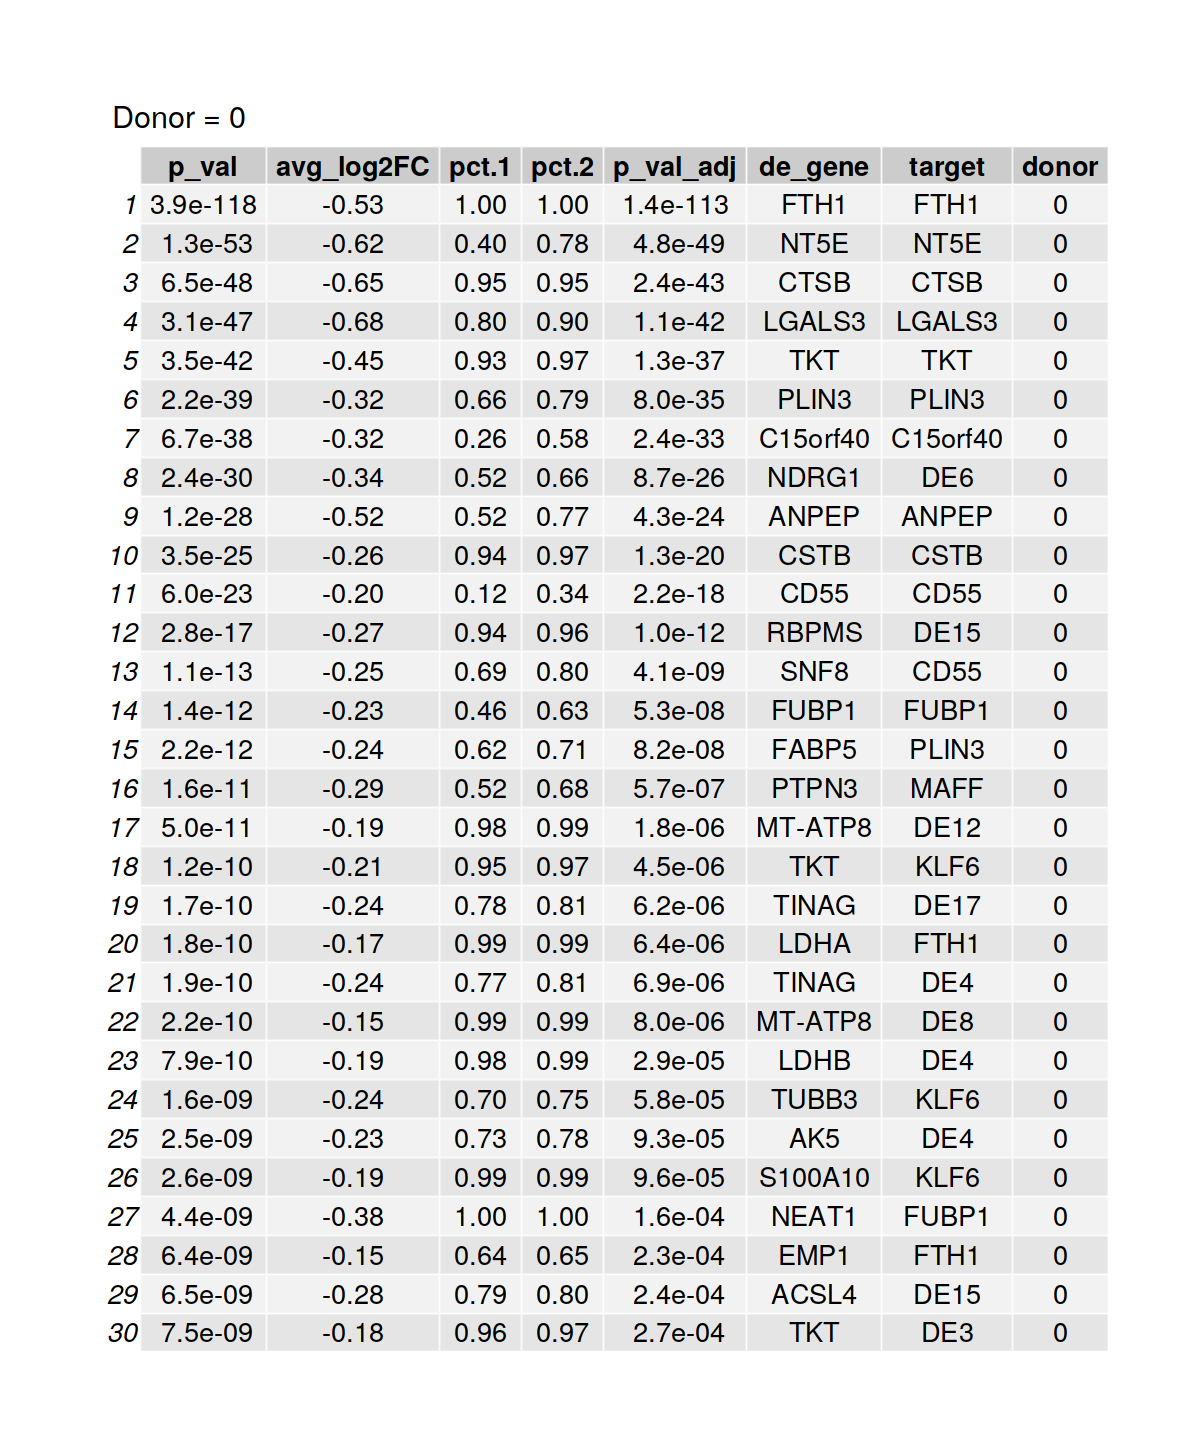

2 


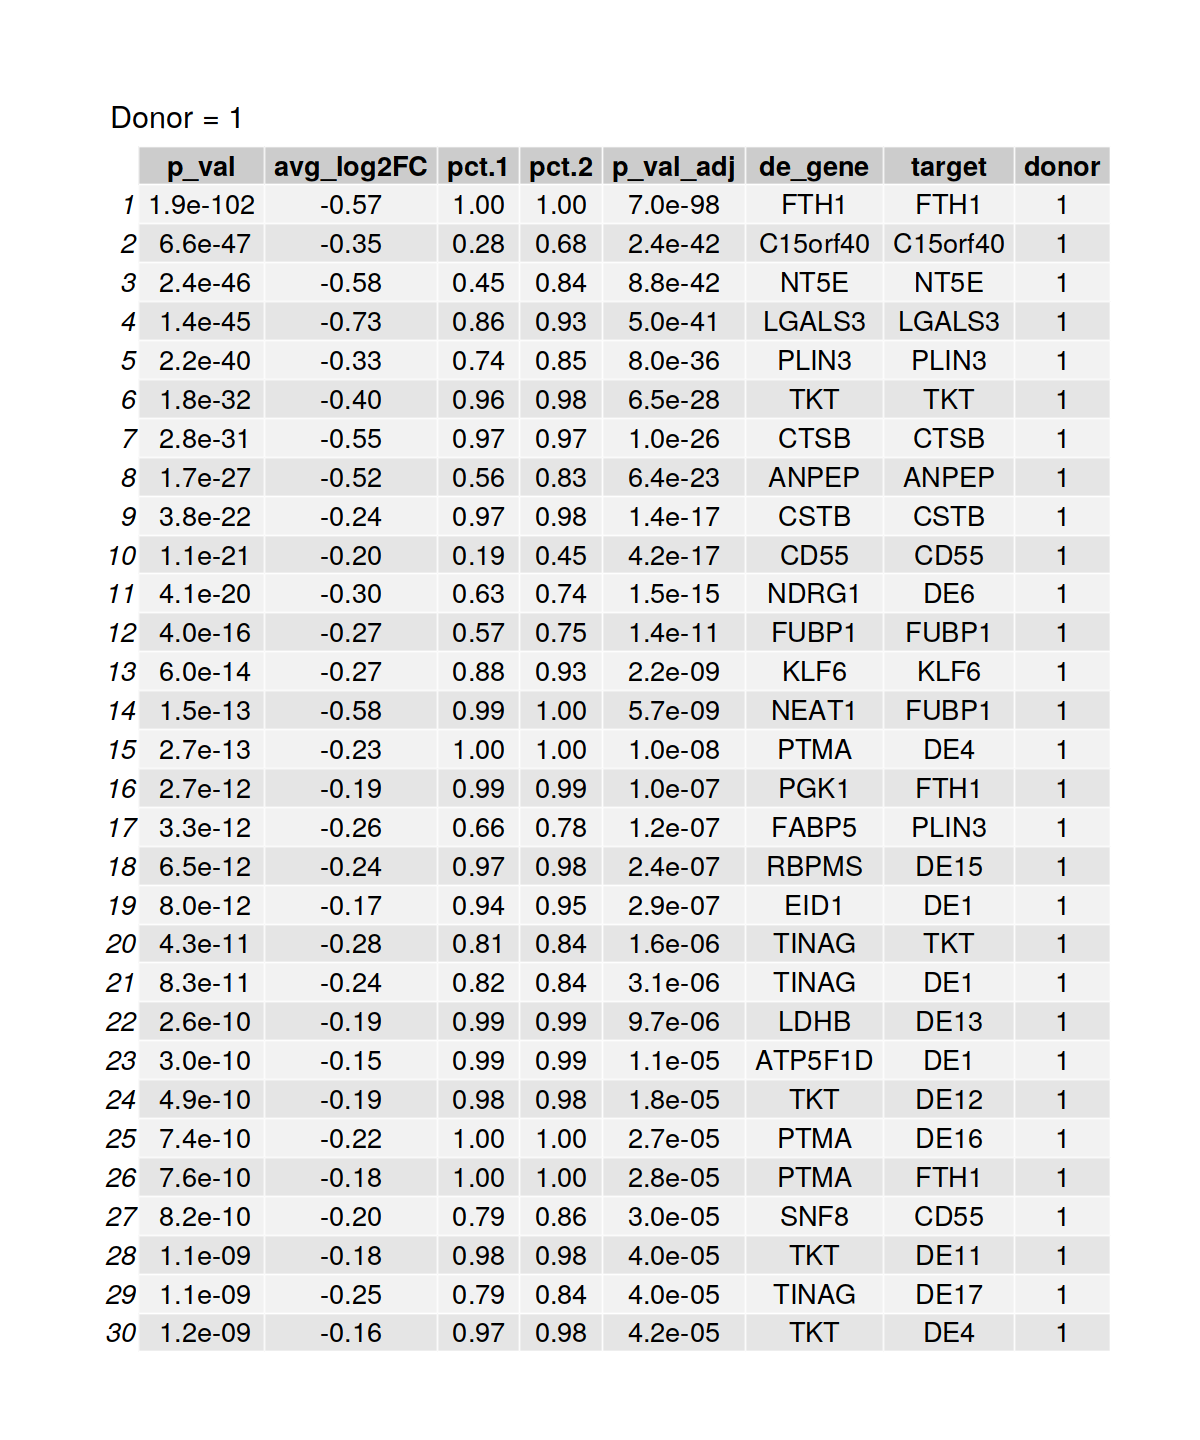

3 


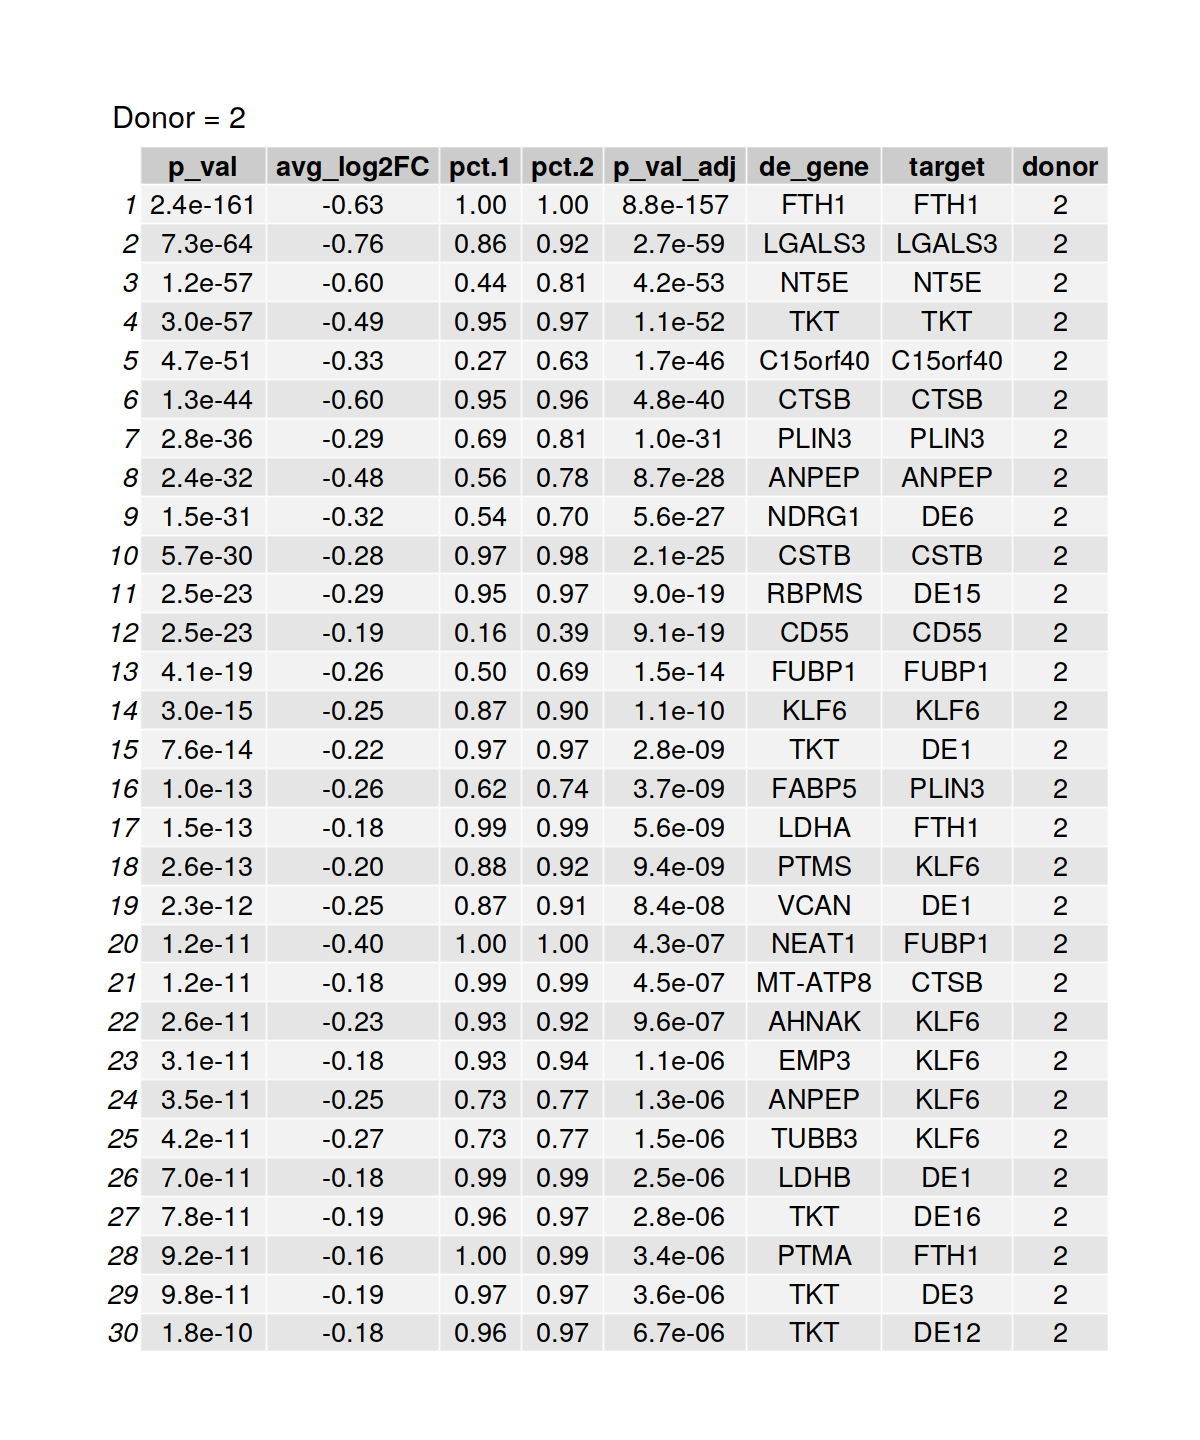

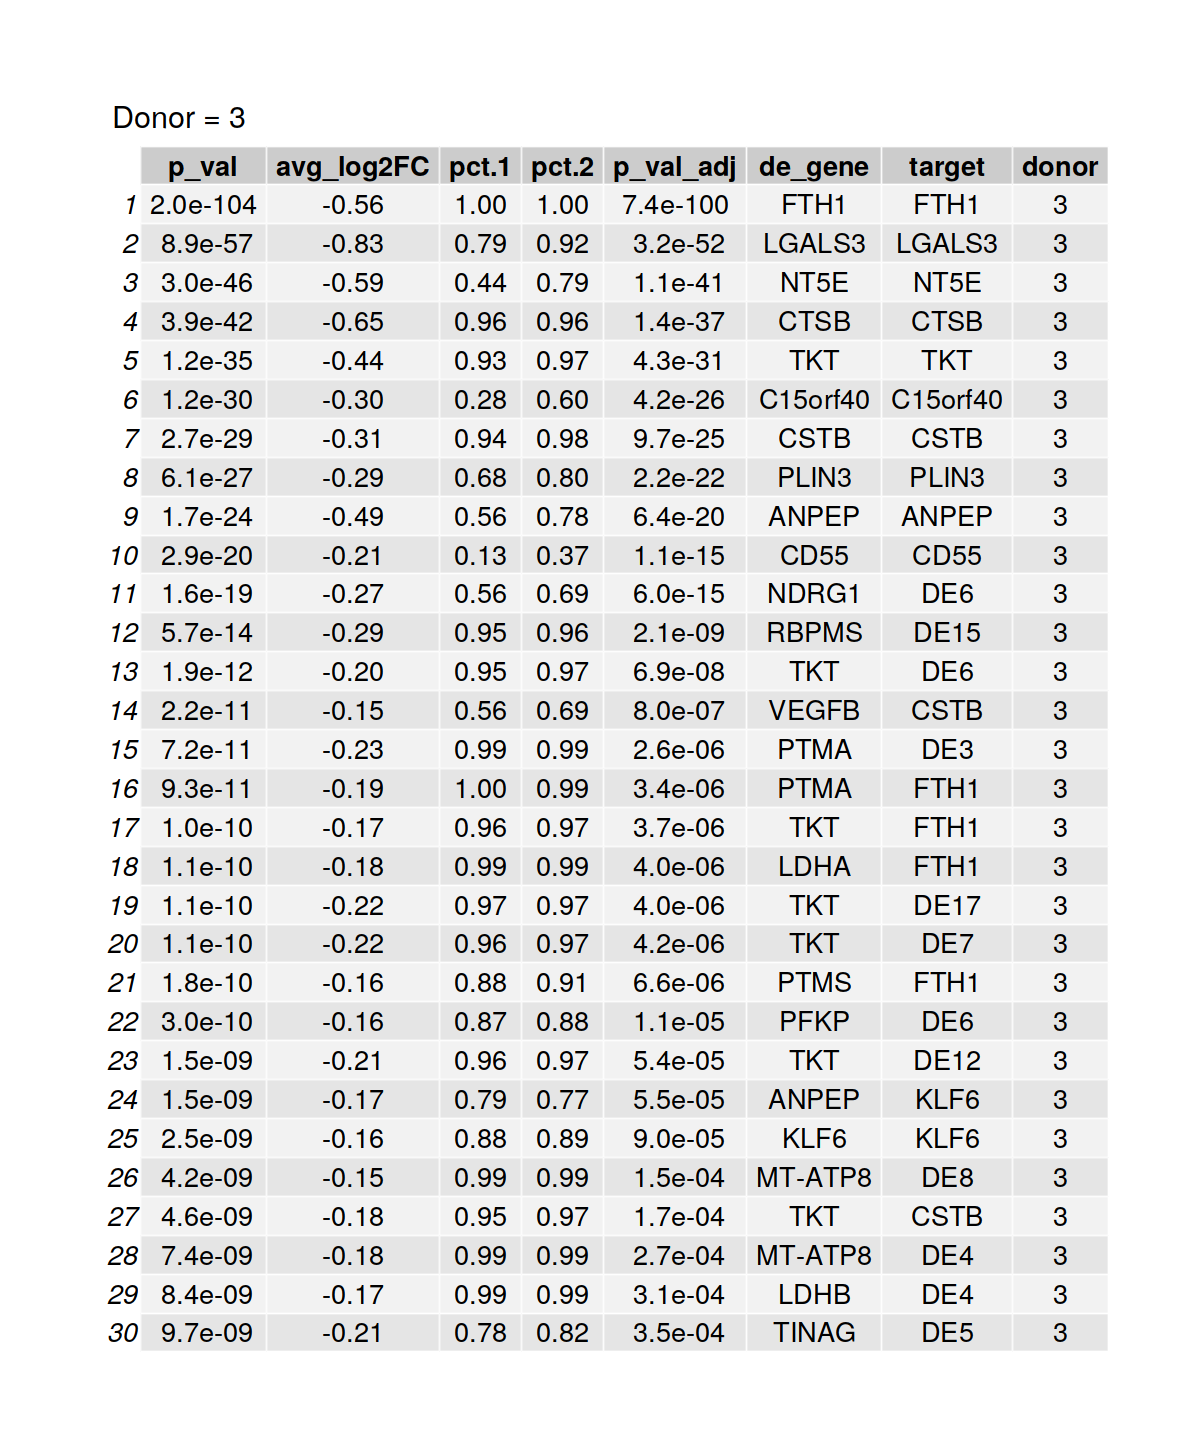

In [18]:
library(huxtable)
options(repr.plot.width = 10, repr.plot.height = 12)
for(donor_id in donors) {
    df_dummy = df_de %>% filter(avg_log2FC < 0 & p_val_adj < 0.05) %>% filter(donor == donor_id) %>% arrange(p_val_adj) %>% head(30)
    cat(green(donor_id, "\n"))
    title <- paste0("Donor = ", donor_id)
    tb <- ggtexttable(df_dummy, theme= ttheme(base_size = 16)) %>% tab_add_title(text = title, face = "plain", size = 18)
    print(tb)
}


## TSS controls

[1] "ANPEP"
CD13-1a   245 
CD13-1b   334 
Guide+ = 334 ; Guide- = 5405 
[1] "CD55"
CD55-1a   265 
CD55-1b   348 
Guide+ = 348 ; Guide- = 5391 
[1] "NT5E"
CD73-1a   221 
CD73-1b   302 
Guide+ = 302 ; Guide- = 5437 
[1] "FUBP1"
FUBP1-1a   204 
FUBP1-1b   272 
Guide+ = 272 ; Guide- = 5467 
[1] "C15orf40"
C15orf40-1a   245 
C15orf40-1b   325 
Guide+ = 325 ; Guide- = 5414 
[1] "MAFF"
MAFF-1a   211 
MAFF-1b   266 
Guide+ = 266 ; Guide- = 5473 
[1] "ANPEP"
CD13-1a   217 
CD13-1b   277 
Guide+ = 277 ; Guide- = 4284 
[1] "CD55"
CD55-1a   193 
CD55-1b   264 
Guide+ = 264 ; Guide- = 4297 
[1] "NT5E"
CD73-1a   172 
CD73-1b   240 
Guide+ = 240 ; Guide- = 4321 
[1] "FUBP1"
FUBP1-1a   178 
FUBP1-1b   220 
Guide+ = 220 ; Guide- = 4341 
[1] "C15orf40"
C15orf40-1a   195 
C15orf40-1b   263 
Guide+ = 263 ; Guide- = 4298 
[1] "MAFF"
MAFF-1a   174 
MAFF-1b   227 
Guide+ = 227 ; Guide- = 4334 


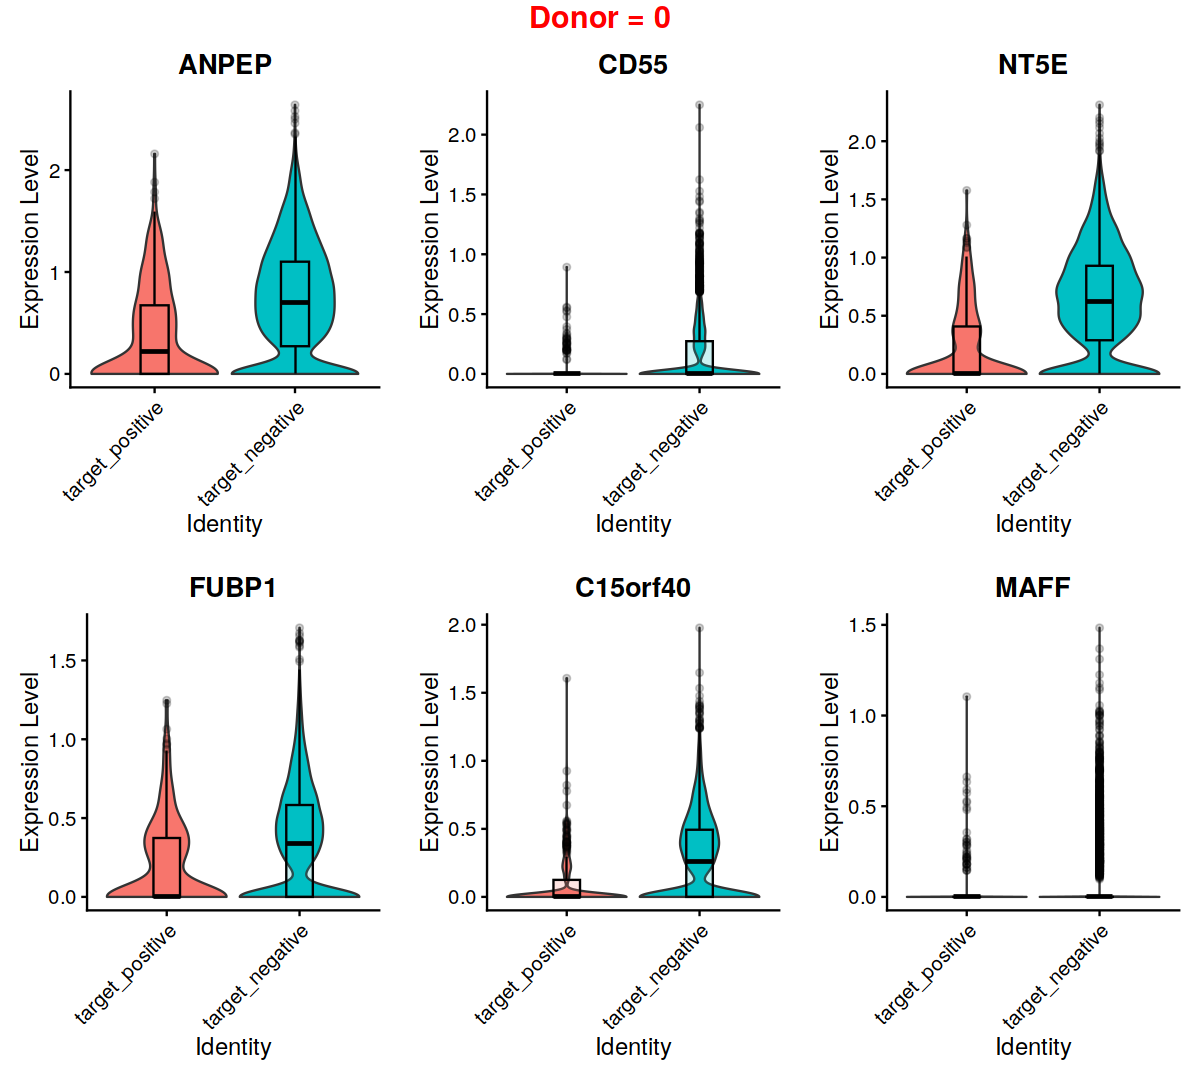

[1] "ANPEP"
CD13-1a   322 
CD13-1b   425 
Guide+ = 425 ; Guide- = 5746 
[1] "CD55"
CD55-1a   266 
CD55-1b   372 
Guide+ = 372 ; Guide- = 5799 
[1] "NT5E"
CD73-1a   248 
CD73-1b   331 
Guide+ = 331 ; Guide- = 5840 
[1] "FUBP1"
FUBP1-1a   240 
FUBP1-1b   315 
Guide+ = 315 ; Guide- = 5856 
[1] "C15orf40"
C15orf40-1a   278 
C15orf40-1b   367 
Guide+ = 367 ; Guide- = 5804 
[1] "MAFF"
MAFF-1a   208 
MAFF-1b   288 
Guide+ = 288 ; Guide- = 5883 


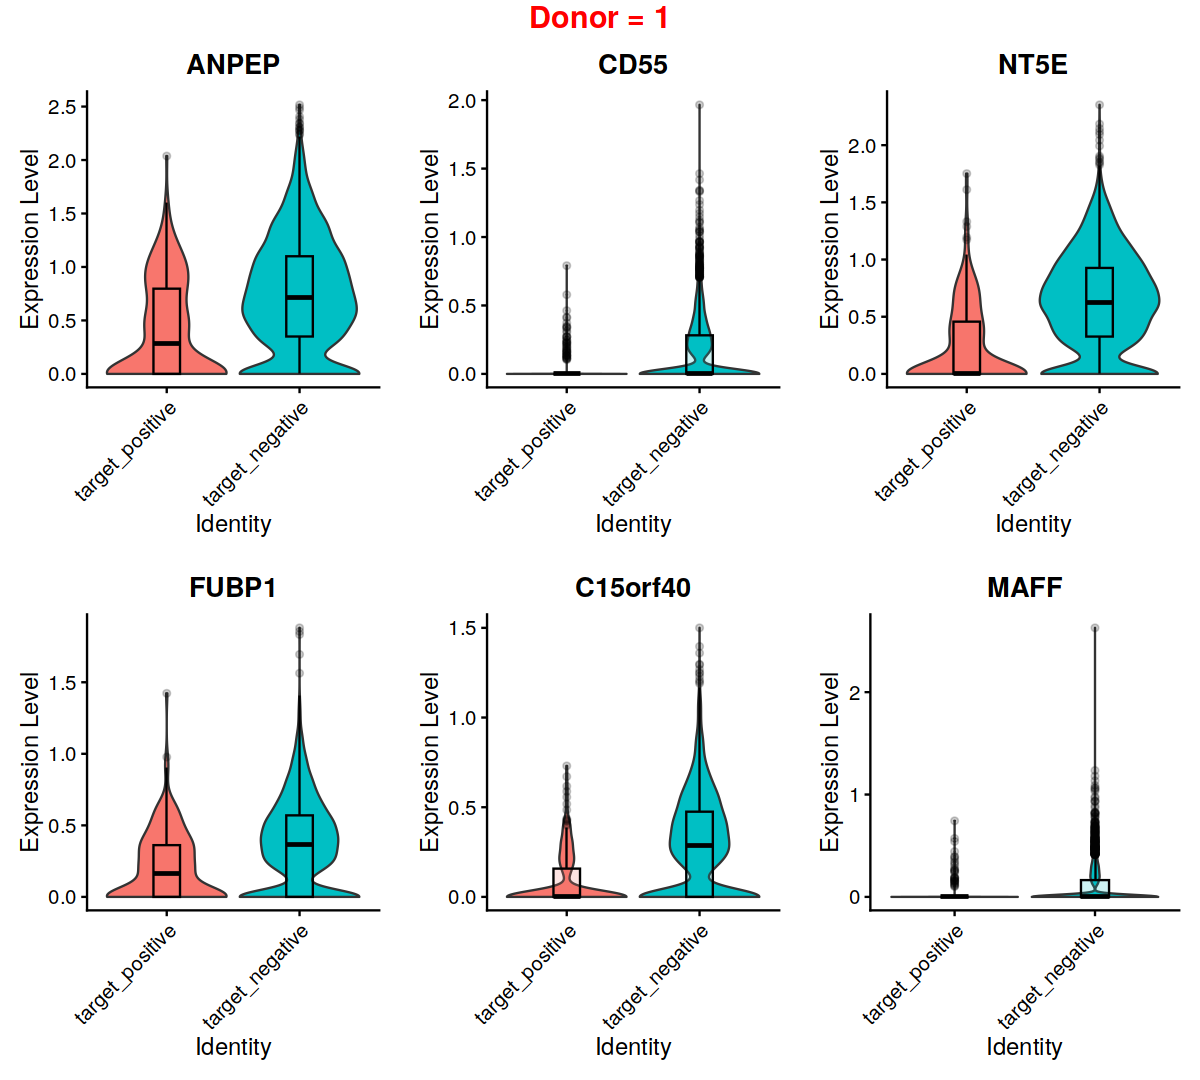

[1] "ANPEP"
CD13-1a   219 
CD13-1b   300 
Guide+ = 300 ; Guide- = 4467 
[1] "CD55"
CD55-1a   195 
CD55-1b   268 
Guide+ = 268 ; Guide- = 4499 
[1] "NT5E"
CD73-1a   208 
CD73-1b   286 
Guide+ = 286 ; Guide- = 4481 
[1] "FUBP1"
FUBP1-1a   160 
FUBP1-1b   217 
Guide+ = 217 ; Guide- = 4550 
[1] "C15orf40"
C15orf40-1a   227 
C15orf40-1b   285 
Guide+ = 285 ; Guide- = 4482 
[1] "MAFF"
MAFF-1a   173 
MAFF-1b   218 
Guide+ = 218 ; Guide- = 4549 


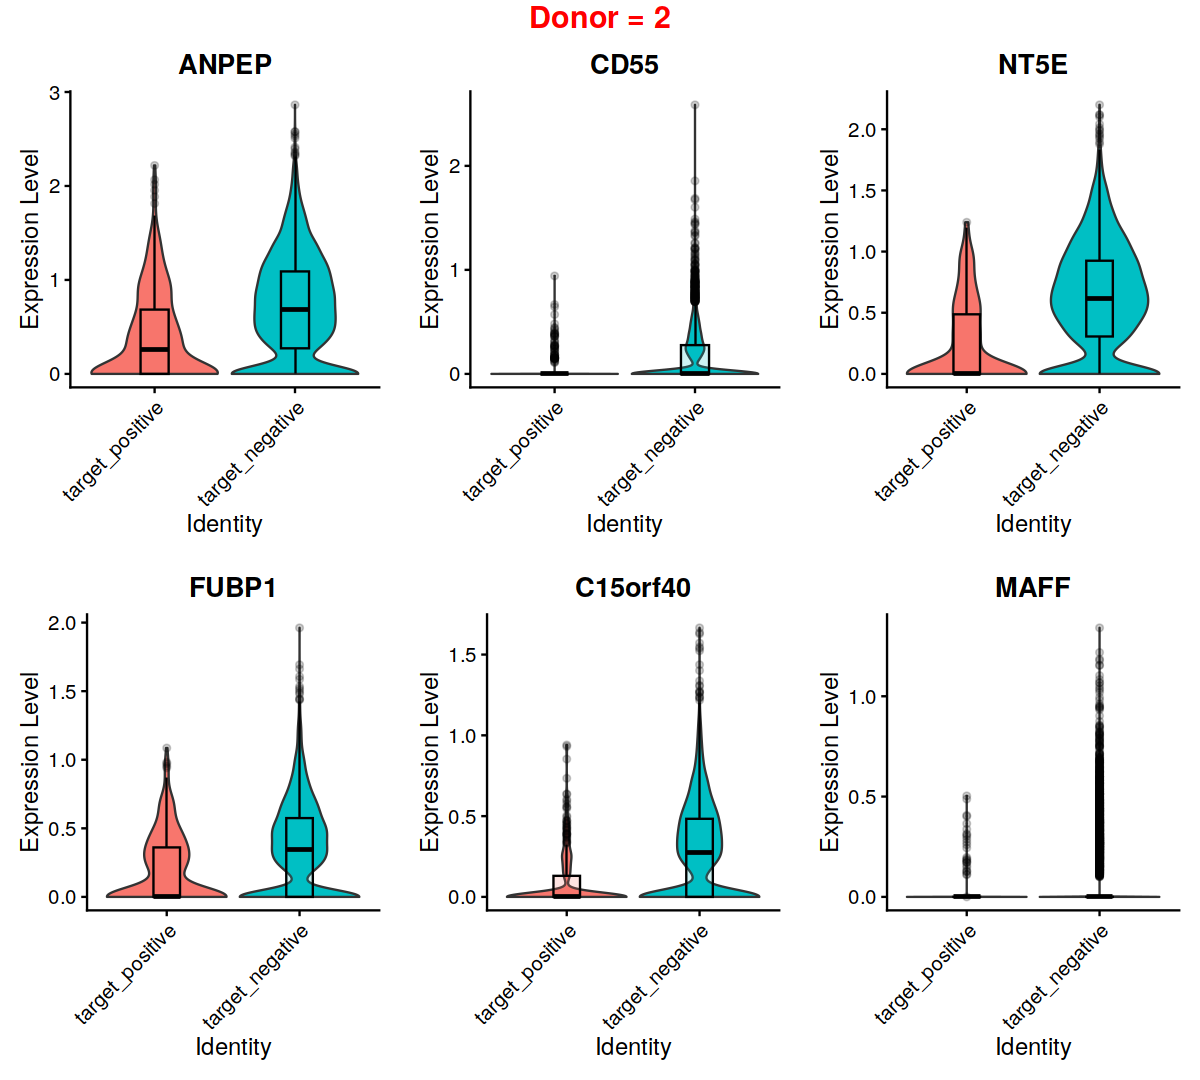

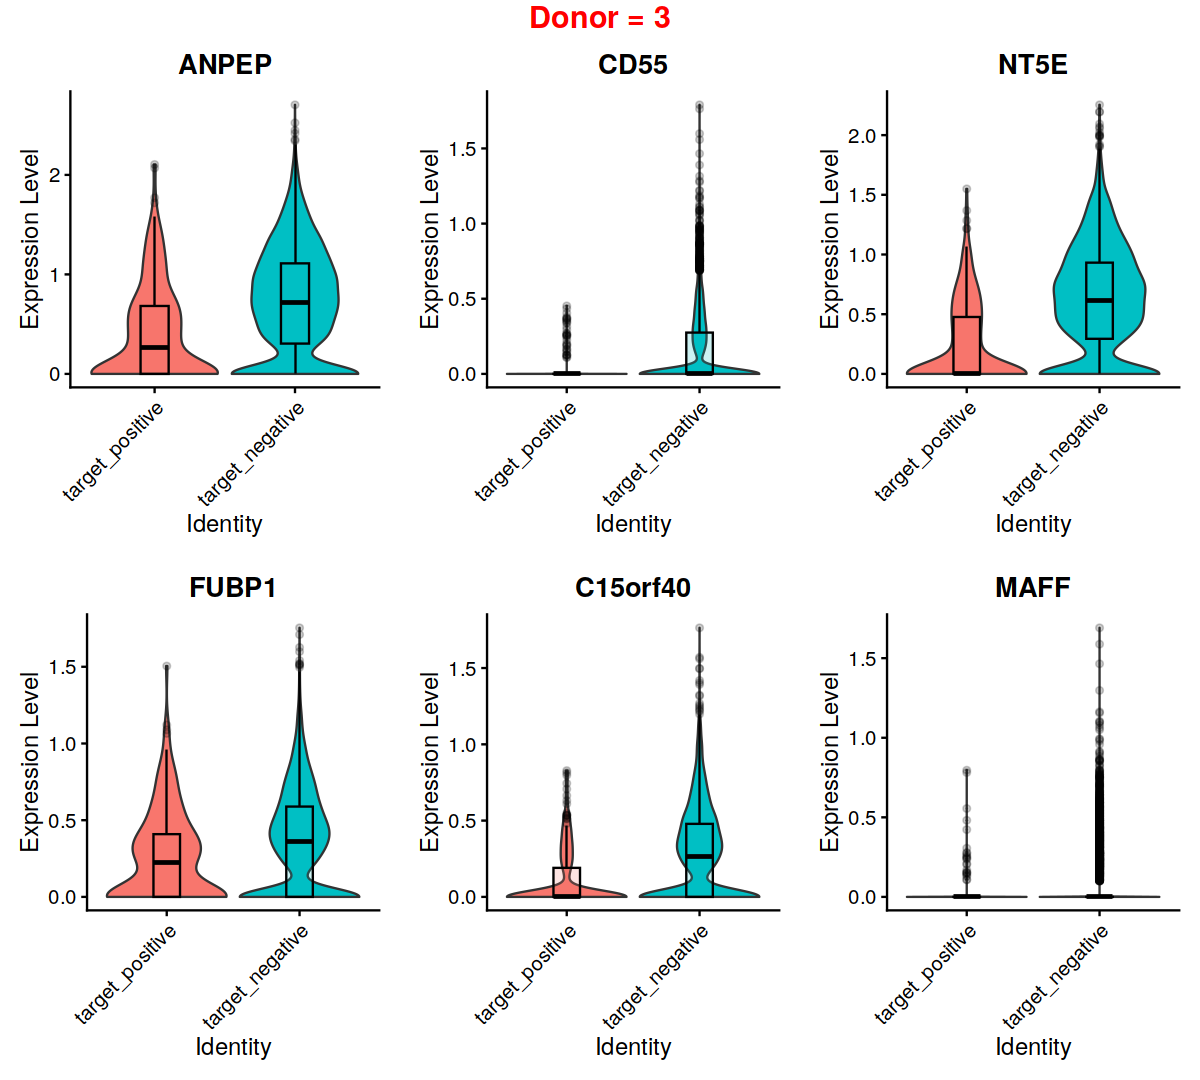

In [20]:
donors = sort(unique(seurat_rna$donor))

for(donor_id in donors) {
    targets = unique(filter(df_guide, subclass=='de_control')$alias)
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined,df_thresholds, donor_id)

    targets = unique(filter(df_guide, subclass=='tss')$alias)
    plots = vlnplot_for_targets(seurat_donor, df_guide, perturbed_cells_by_guide, targets)
    title <- paste0("Donor = ", donor_id)
    options(repr.plot.width=10, repr.plot.height=9)
    p <- ggarrange(plotlist=plots, ncol=3, nrow = 2)
    p <- annotate_figure(p, top = text_grob(title, color = "red", face = "bold", size = 18))
    print(p)
}

## DE controls

[1] "FTH1"
FTH1-1a   163 
FTH1-2a   945 
FTH1-1b   1000 
FTH1-2b   1000 
Guide+ = 1000 ; Guide- = 4739 
[1] "PLIN3"
PLIN3-1a   242 
PLIN3-2a   463 
PLIN3-1b   542 
PLIN3-2b   608 
Guide+ = 608 ; Guide- = 5131 
[1] "TKT"
TKT-1a   189 
TKT-2a   436 
TKT-1b   493 
TKT-2b   575 
Guide+ = 575 ; Guide- = 5164 
[1] "LGALS3"
LGALS3-1a   270 
LGALS3-2a   482 
LGALS3-1b   559 
LGALS3-2b   621 
Guide+ = 621 ; Guide- = 5118 
[1] "CSTB"
CSTB-1a   290 
CSTB-2a   544 
CSTB-1b   620 
CSTB-2b   688 
Guide+ = 688 ; Guide- = 5051 
[1] "CTSB"
CTSB-1a   316 
CTSB-2a   544 
CTSB-1b   611 
CTSB-2b   663 
Guide+ = 663 ; Guide- = 5076 
[1] "KLF6"
KLF6-1a   284 
KLF6-2a   532 
KLF6-1b   601 
KLF6-2b   650 
Guide+ = 650 ; Guide- = 5089 
[1] "FTH1"
FTH1-1a   162 
FTH1-2a   789 
FTH1-1b   841 
FTH1-2b   841 
Guide+ = 841 ; Guide- = 3720 
[1] "PLIN3"
PLIN3-1a   234 
PLIN3-2a   423 
PLIN3-1b   483 
PLIN3-2b   533 
Guide+ = 533 ; Guide- = 4028 
[1] "TKT"
TKT-1a   189 
TKT-2a   371 
TKT-1b   426 
TKT-2b   485 
Guide+ 

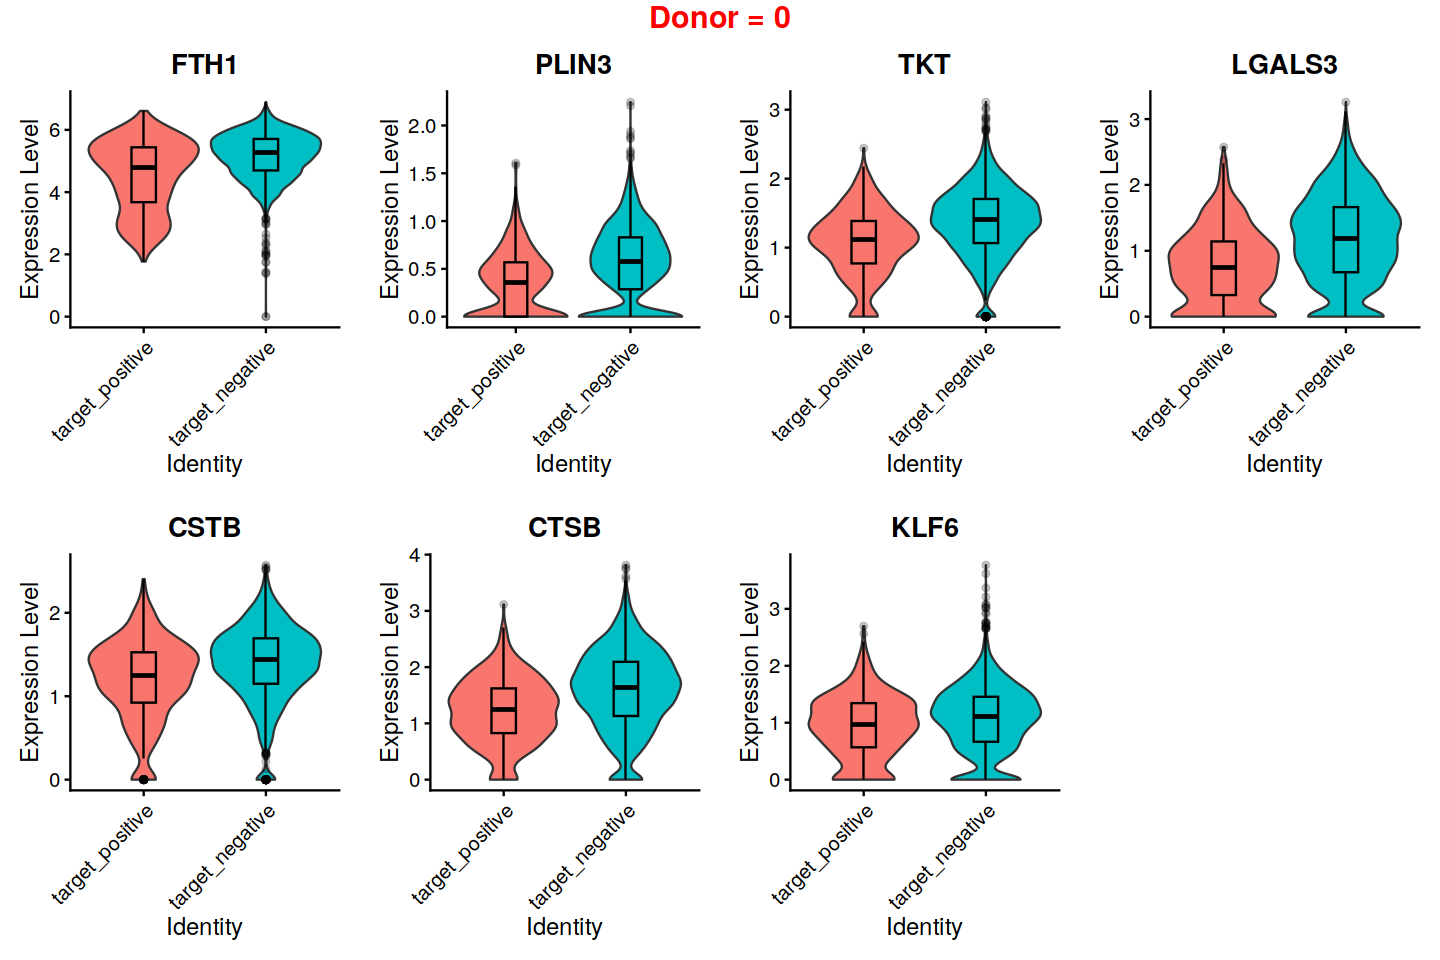

[1] "FTH1"
FTH1-1a   208 
FTH1-2a   1070 
FTH1-1b   1127 
FTH1-2b   1127 
Guide+ = 1127 ; Guide- = 5044 
[1] "PLIN3"
PLIN3-1a   283 
PLIN3-2a   502 
PLIN3-1b   564 
PLIN3-2b   651 
Guide+ = 651 ; Guide- = 5520 
[1] "TKT"
TKT-1a   207 
TKT-2a   476 
TKT-1b   549 
TKT-2b   649 
Guide+ = 649 ; Guide- = 5522 
[1] "LGALS3"
LGALS3-1a   309 
LGALS3-2a   554 
LGALS3-1b   632 
LGALS3-2b   710 
Guide+ = 710 ; Guide- = 5461 
[1] "CSTB"
CSTB-1a   273 
CSTB-2a   543 
CSTB-1b   629 
CSTB-2b   704 
Guide+ = 704 ; Guide- = 5467 
[1] "CTSB"
CTSB-1a   334 
CTSB-2a   585 
CTSB-1b   668 
CTSB-2b   714 
Guide+ = 714 ; Guide- = 5457 
[1] "KLF6"
KLF6-1a   282 
KLF6-2a   533 
KLF6-1b   618 
KLF6-2b   690 
Guide+ = 690 ; Guide- = 5481 


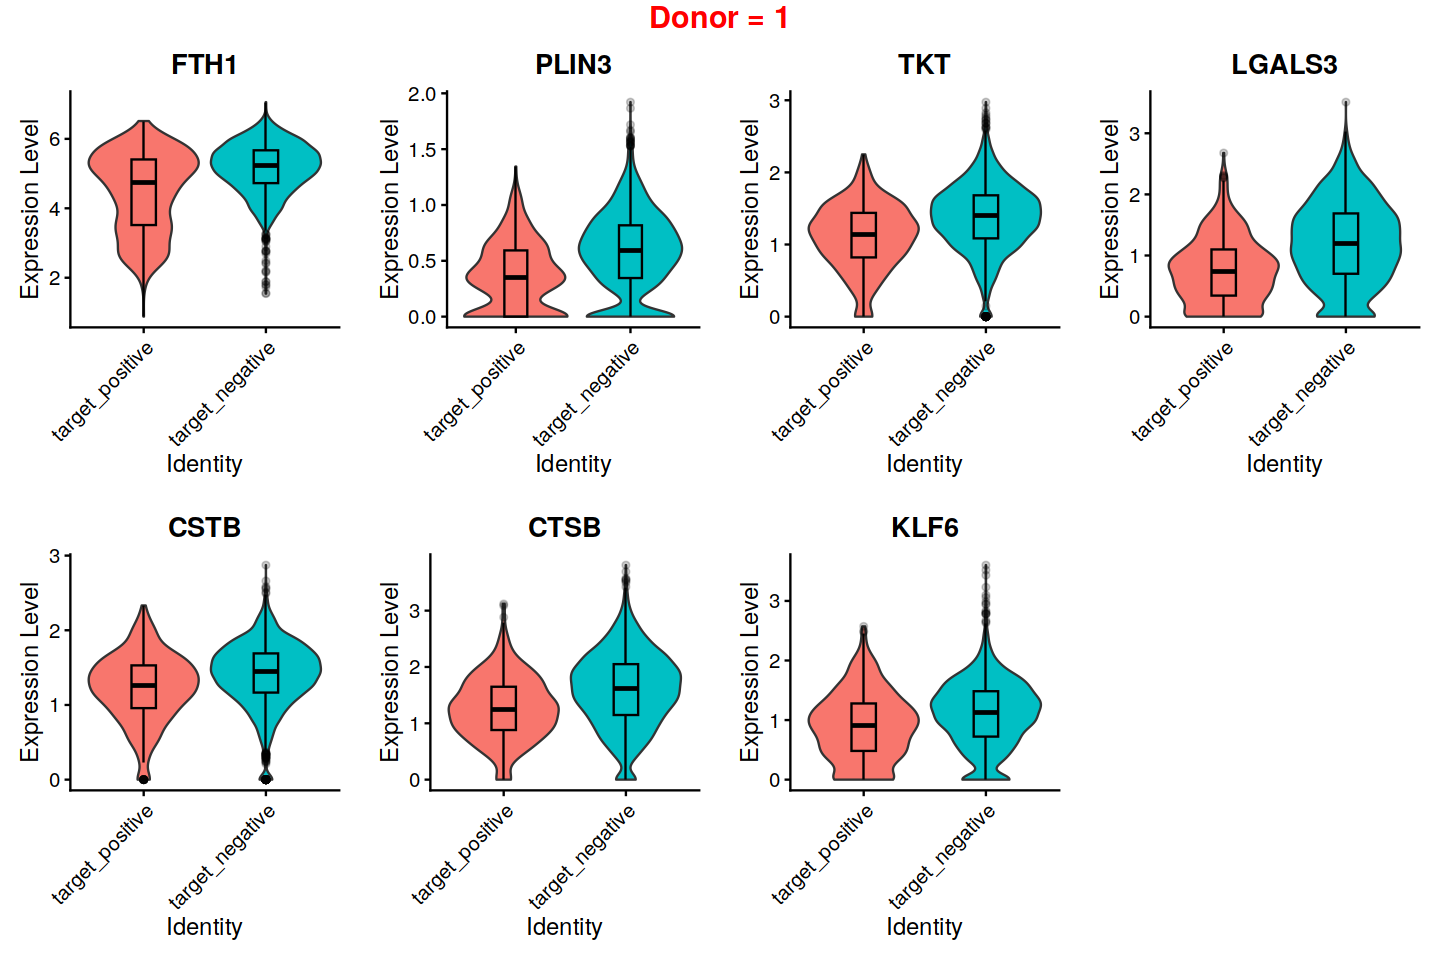

[1] "FTH1"
FTH1-1a   164 
FTH1-2a   865 
FTH1-1b   916 
FTH1-2b   916 
Guide+ = 916 ; Guide- = 3851 
[1] "PLIN3"
PLIN3-1a   219 
PLIN3-2a   388 
PLIN3-1b   441 
PLIN3-2b   501 
Guide+ = 501 ; Guide- = 4266 
[1] "TKT"
TKT-1a   176 
TKT-2a   376 
TKT-1b   422 
TKT-2b   491 
Guide+ = 491 ; Guide- = 4276 
[1] "LGALS3"
LGALS3-1a   231 
LGALS3-2a   413 
LGALS3-1b   471 
LGALS3-2b   525 
Guide+ = 525 ; Guide- = 4242 
[1] "CSTB"
CSTB-1a   246 
CSTB-2a   473 
CSTB-1b   528 
CSTB-2b   580 
Guide+ = 580 ; Guide- = 4187 
[1] "CTSB"
CTSB-1a   252 
CTSB-2a   459 
CTSB-1b   507 
CTSB-2b   565 
Guide+ = 565 ; Guide- = 4202 
[1] "KLF6"
KLF6-1a   238 
KLF6-2a   466 
KLF6-1b   543 
KLF6-2b   597 
Guide+ = 597 ; Guide- = 4170 


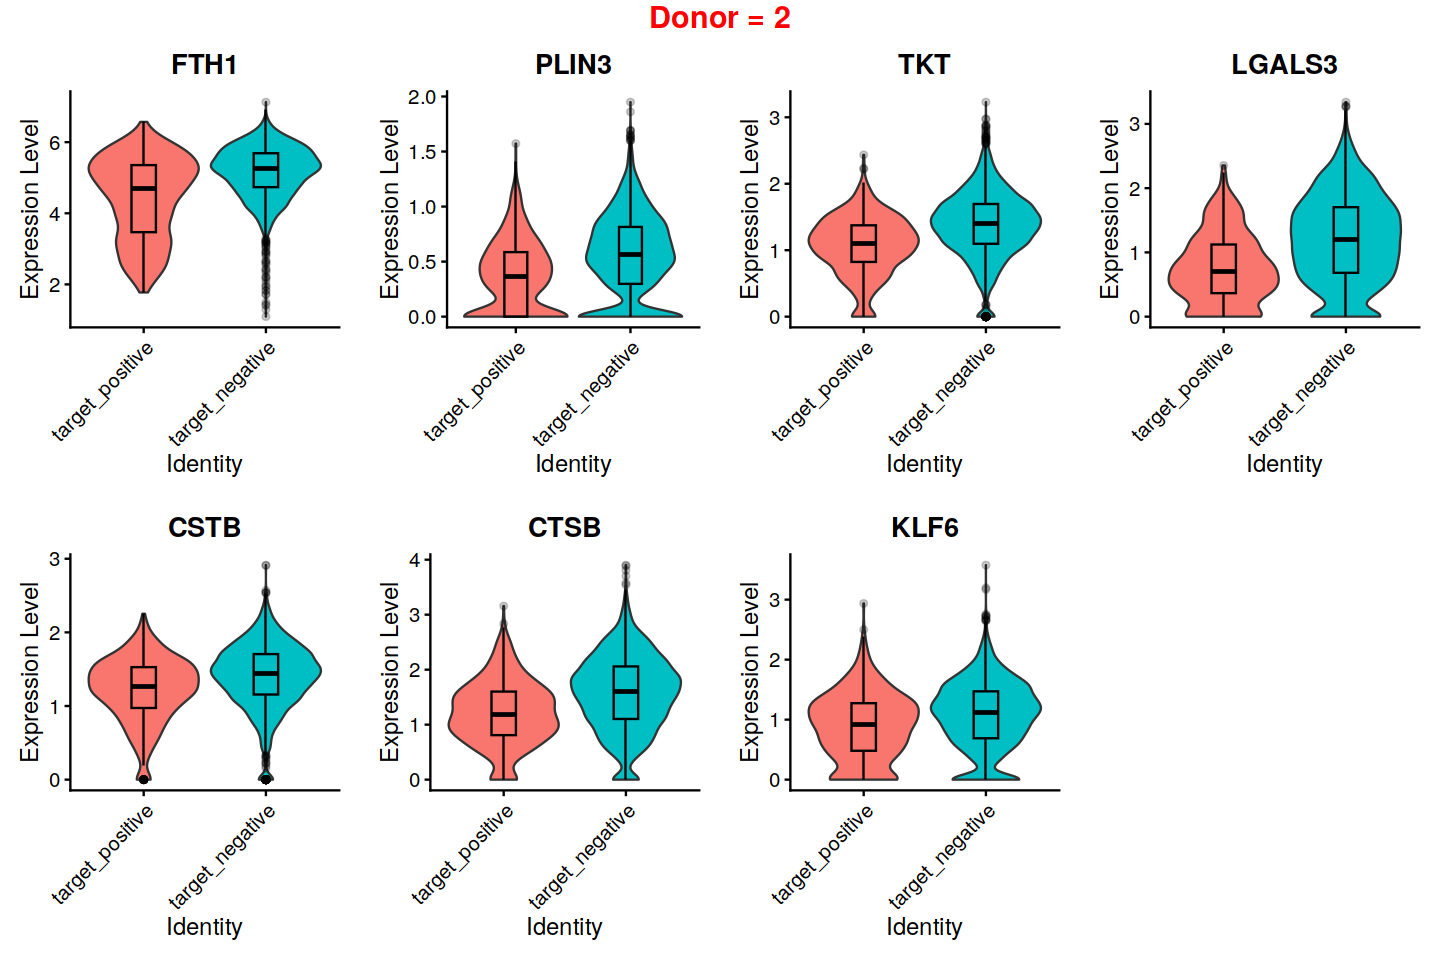

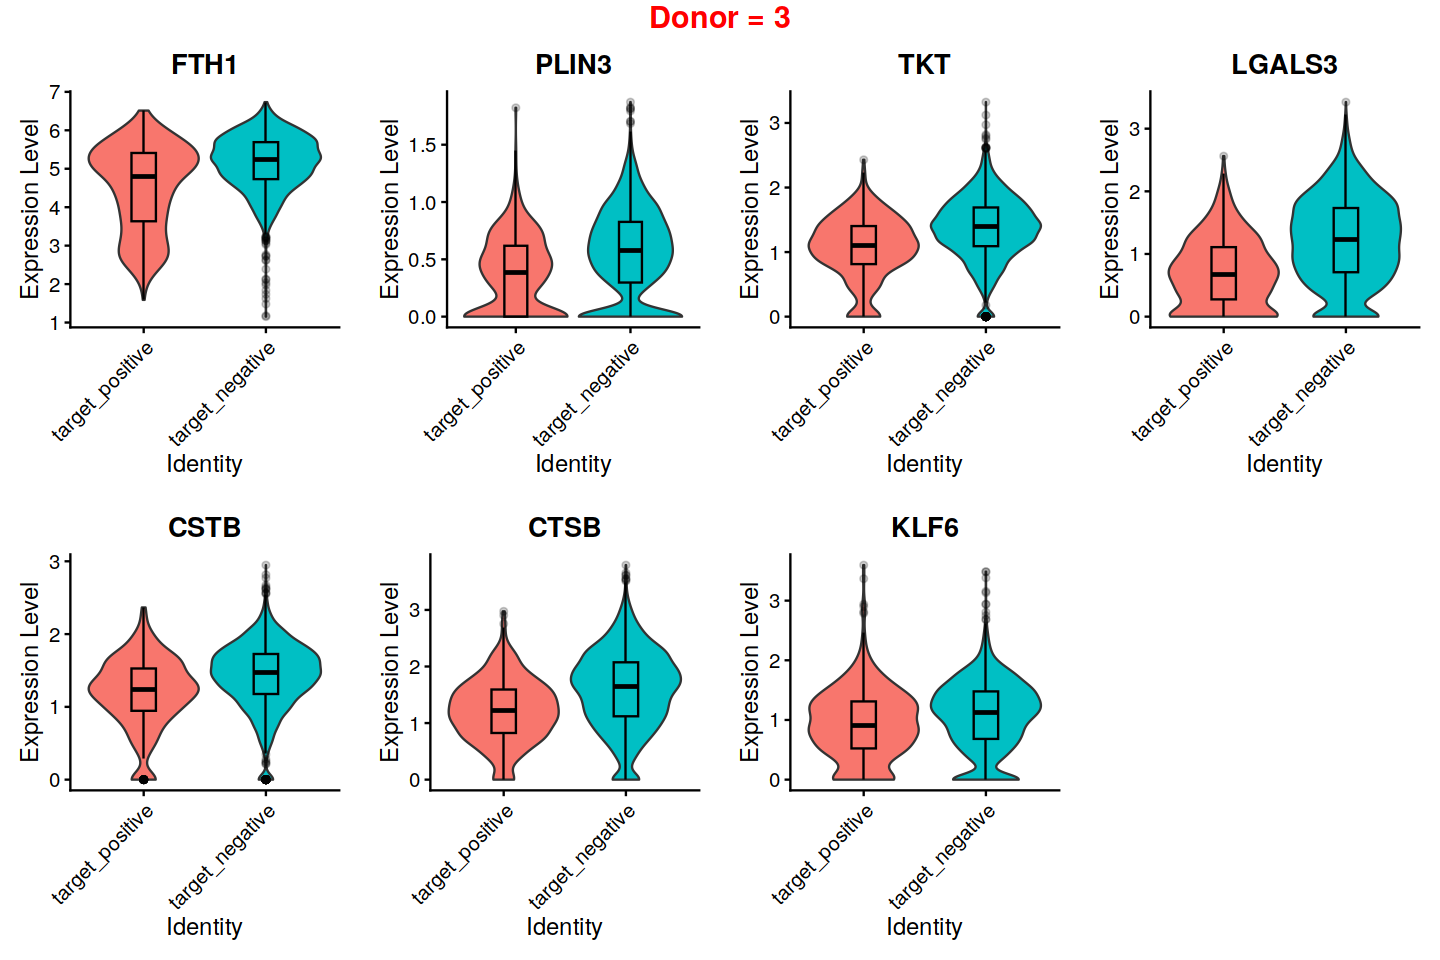

In [22]:
donors = sort(unique(seurat_rna$donor))

for(donor_id in donors) {
    targets = unique(filter(df_guide, subclass=='de_control')$alias)
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, df_thresholds, donor_id)
    
    plots = vlnplot_for_targets(seurat_donor, df_guide, perturbed_cells_by_guide, targets)
    title <- paste0("Donor = ", donor_id)
    options(repr.plot.width=12, repr.plot.height=8)
    p <- ggarrange(plotlist=plots, ncol=4, nrow = 2) 
    p <- annotate_figure(p, top = text_grob(title, color = "red", face = "bold", size = 18))  
    print(p)
}

## CKD DE 

Adding an extra gene or two the regulated_genes list to use as controls

[1] "DE6"
DE6-1a   279 
DE6-2a   821 
DE6-1b   904 
DE6-2b   908 
Guide+ = 908 ; Guide- = 4831 


Picking joint bandwidth of 0.0777

Picking joint bandwidth of 0.0971

Picking joint bandwidth of 0.132



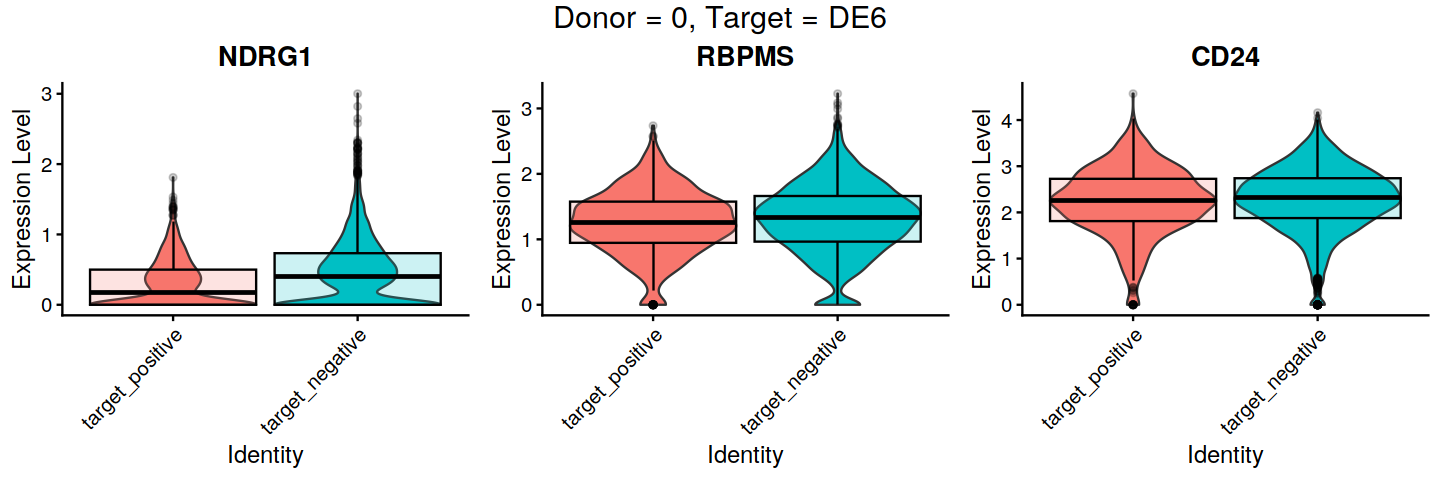

[1] "DE15"
DE15-1a   259 
DE15-2a   543 
DE15-1b   600 
DE15-2b   694 
Guide+ = 694 ; Guide- = 5045 


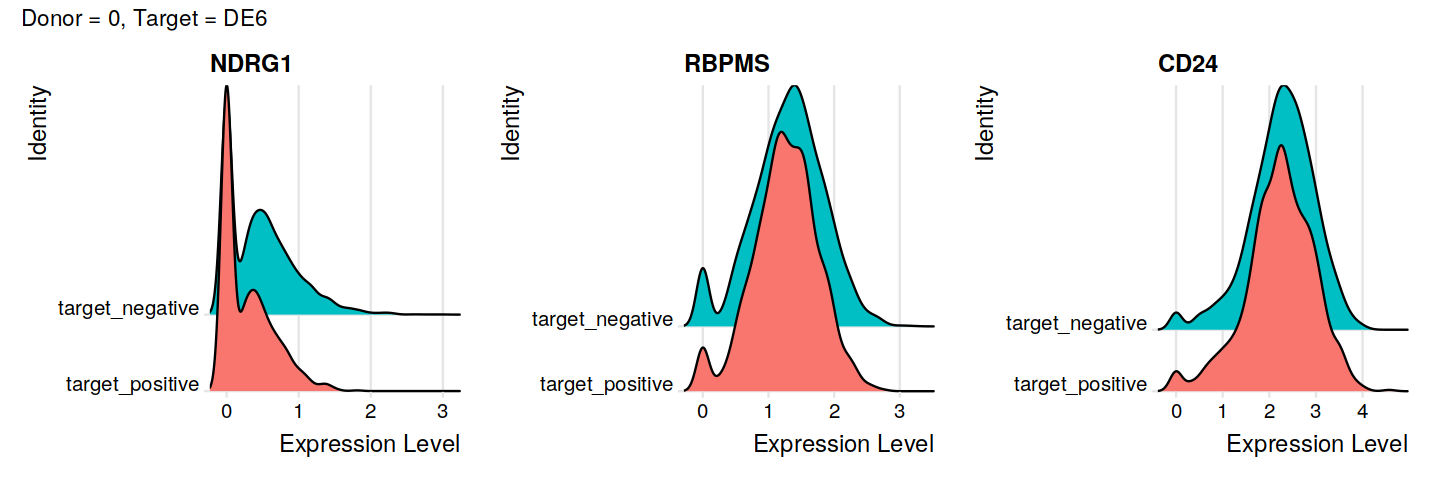

Picking joint bandwidth of 0.0874

Picking joint bandwidth of 0.103

Picking joint bandwidth of 0.13



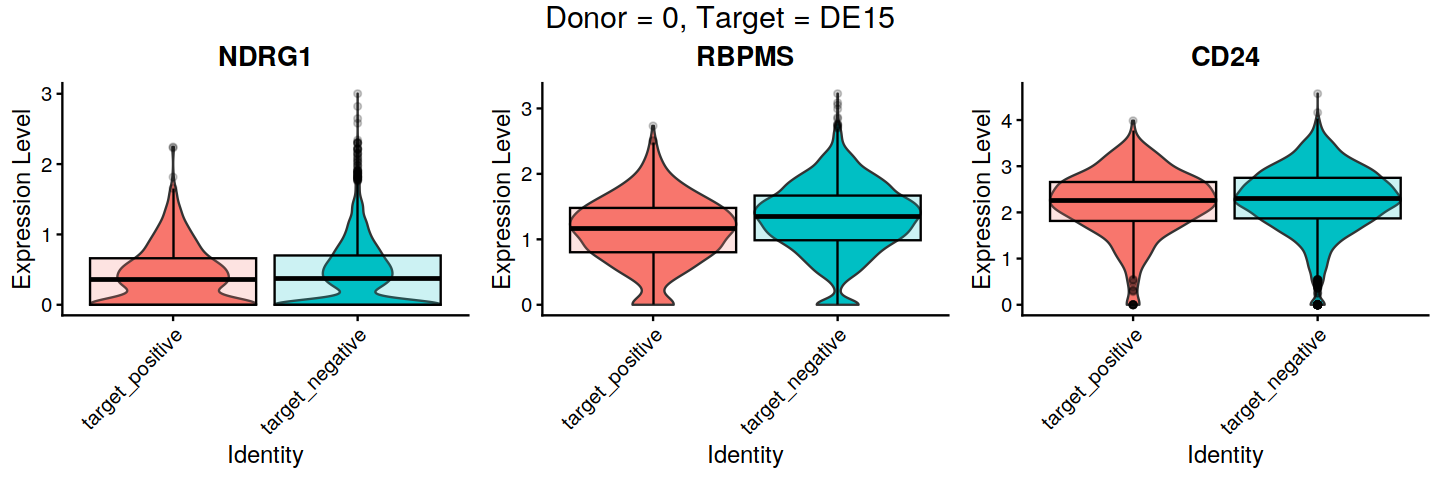

[1] "DE6"
DE6-1a   212 
DE6-2a   615 
DE6-1b   673 
DE6-2b   674 
Guide+ = 674 ; Guide- = 3887 


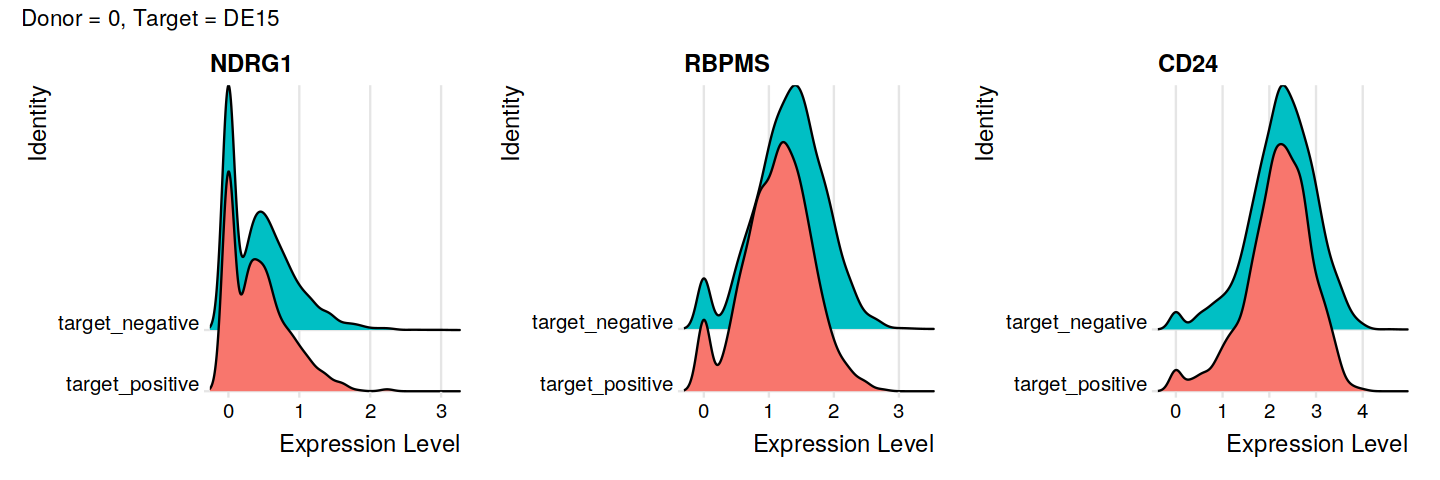

Picking joint bandwidth of 0.079

Picking joint bandwidth of 0.0985

Picking joint bandwidth of 0.133



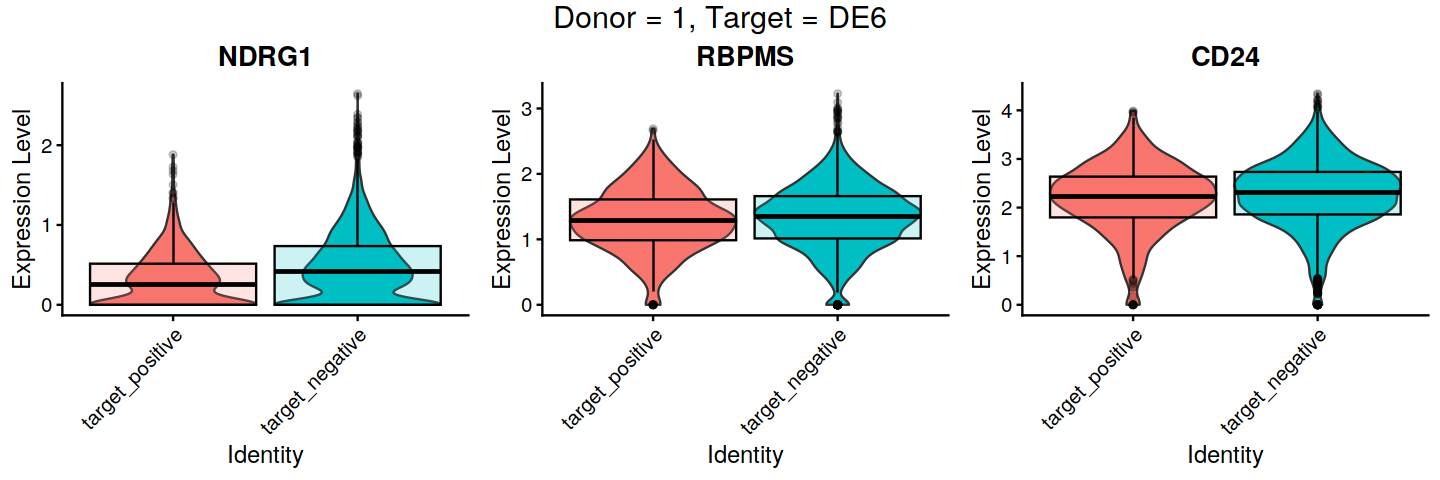

[1] "DE15"
DE15-1a   198 
DE15-2a   440 
DE15-1b   492 
DE15-2b   555 
Guide+ = 555 ; Guide- = 4006 


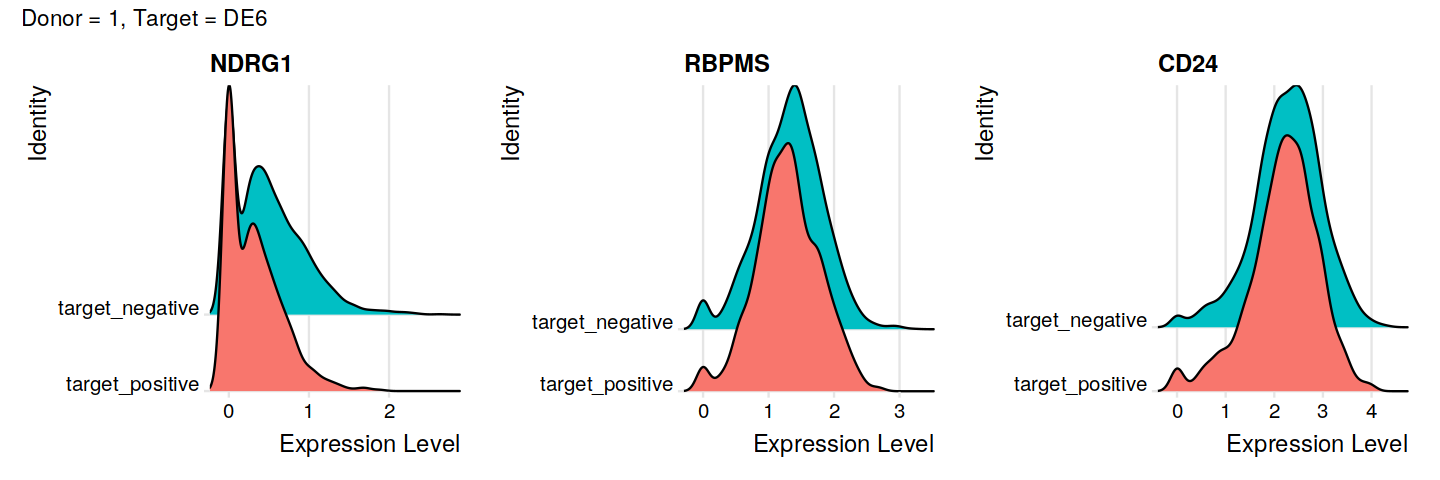

Picking joint bandwidth of 0.0904

Picking joint bandwidth of 0.0992

Picking joint bandwidth of 0.142



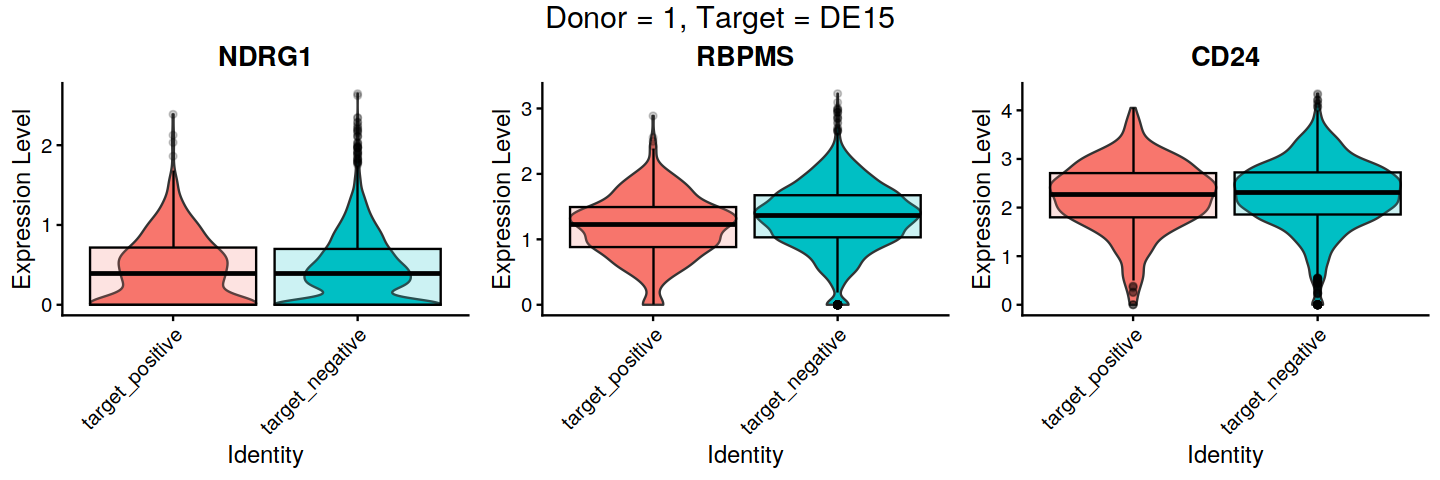

[1] "DE6"
DE6-1a   304 
DE6-2a   839 
DE6-1b   909 
DE6-2b   913 
Guide+ = 913 ; Guide- = 5258 


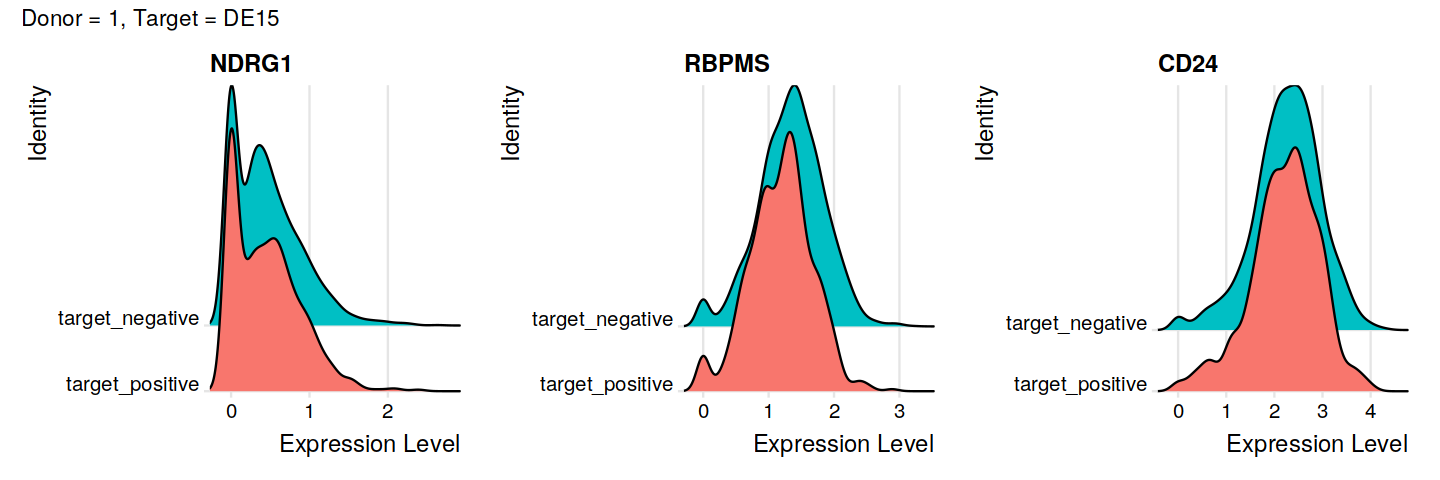

Picking joint bandwidth of 0.0768

Picking joint bandwidth of 0.0953

Picking joint bandwidth of 0.125



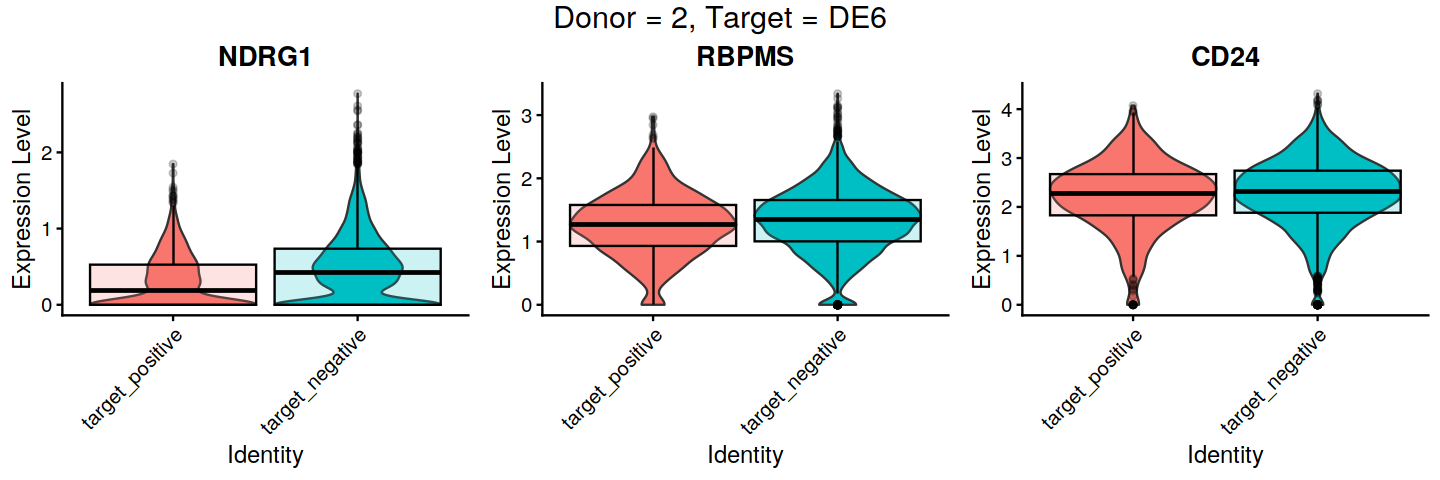

[1] "DE15"
DE15-1a   246 
DE15-2a   542 
DE15-1b   626 
DE15-2b   732 
Guide+ = 732 ; Guide- = 5439 


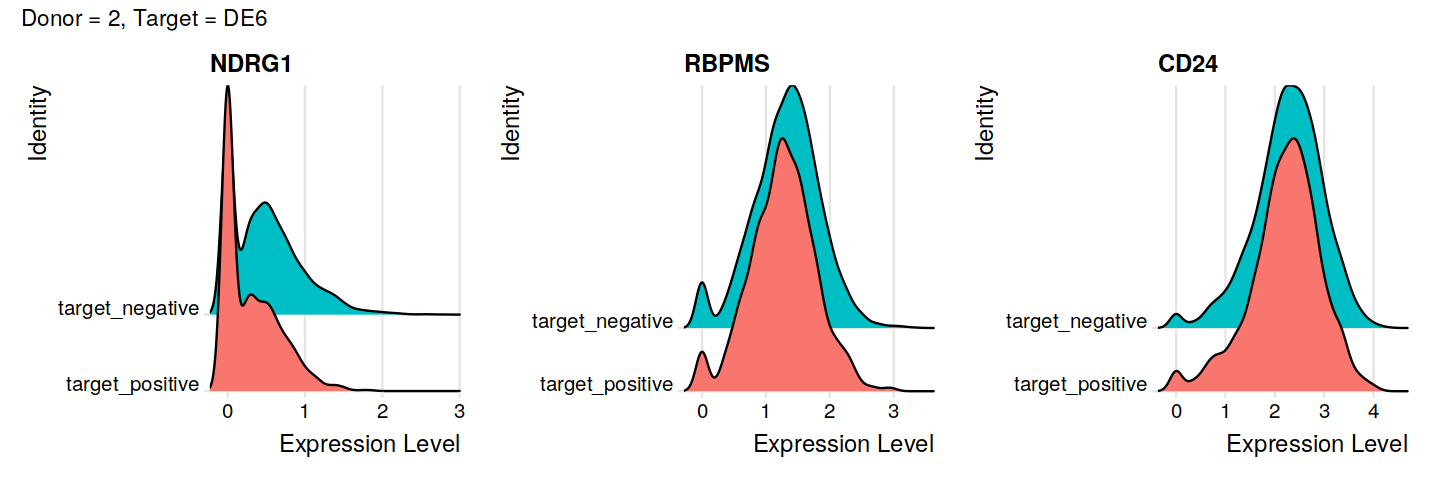

Picking joint bandwidth of 0.0871

Picking joint bandwidth of 0.0965

Picking joint bandwidth of 0.134



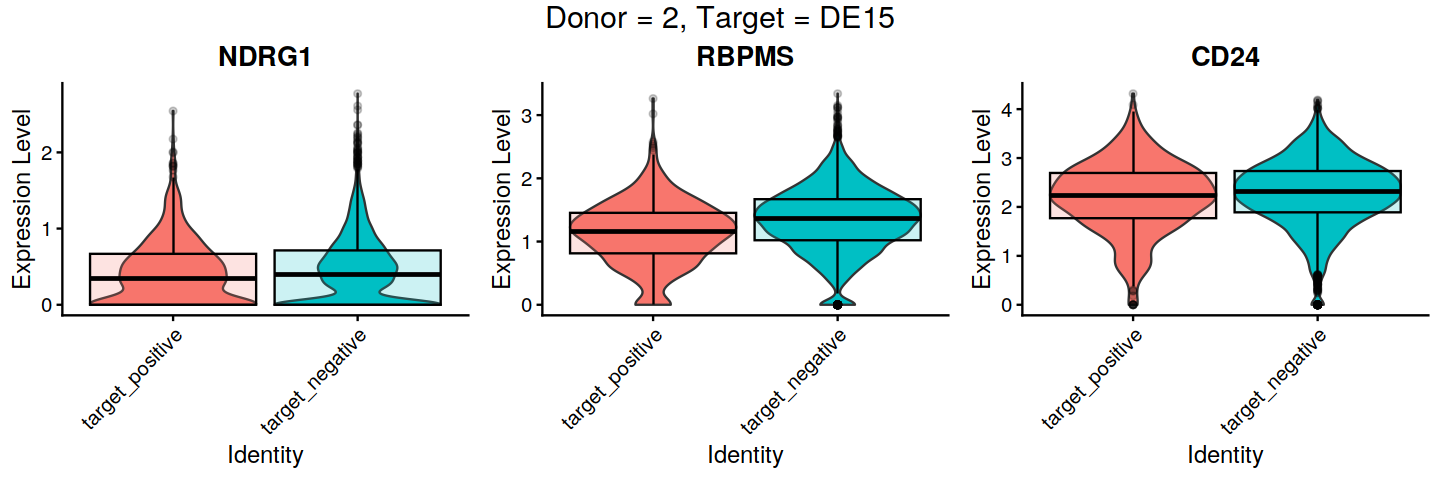

[1] "DE6"
DE6-1a   233 
DE6-2a   628 
DE6-1b   682 
DE6-2b   683 
Guide+ = 683 ; Guide- = 4084 


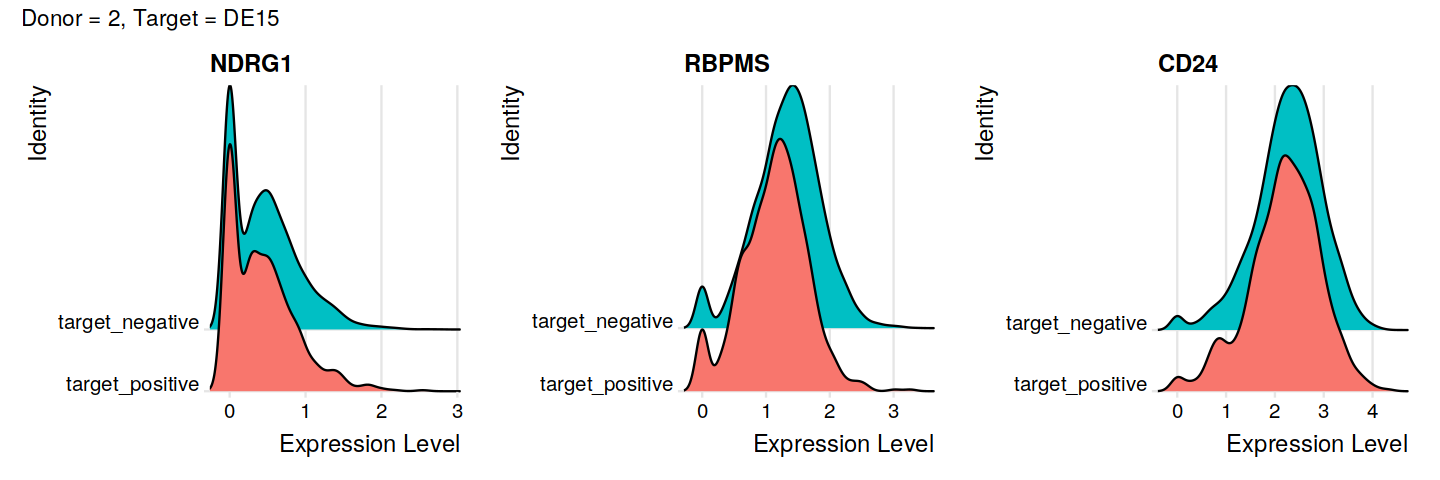

Picking joint bandwidth of 0.0817

Picking joint bandwidth of 0.108

Picking joint bandwidth of 0.125



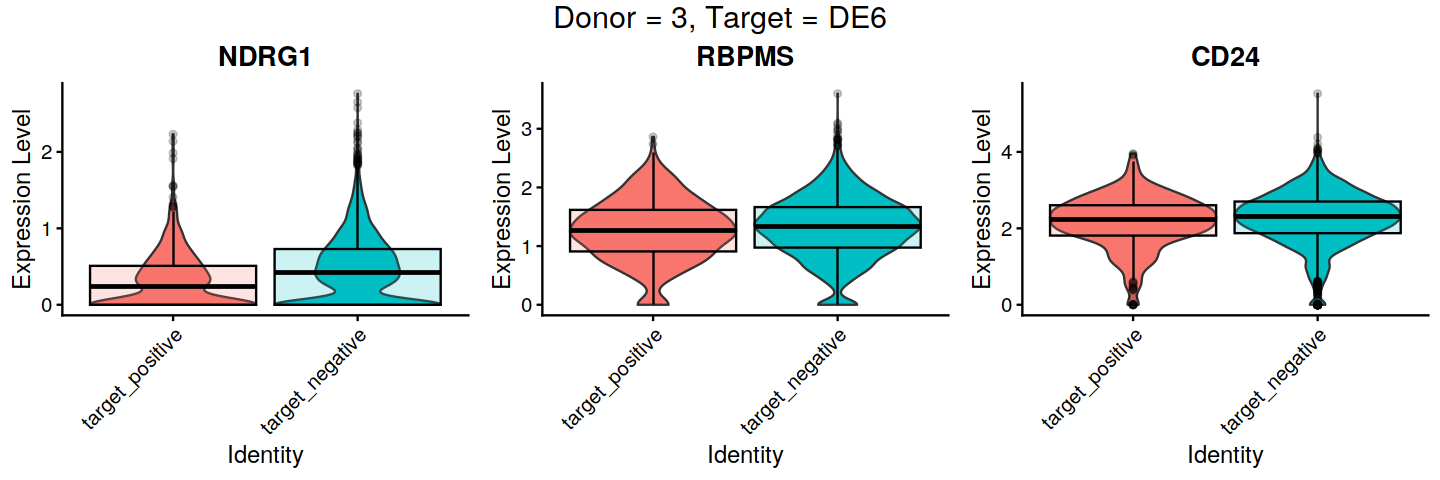

[1] "DE15"
DE15-1a   224 
DE15-2a   501 
DE15-1b   551 
DE15-2b   618 
Guide+ = 618 ; Guide- = 4149 


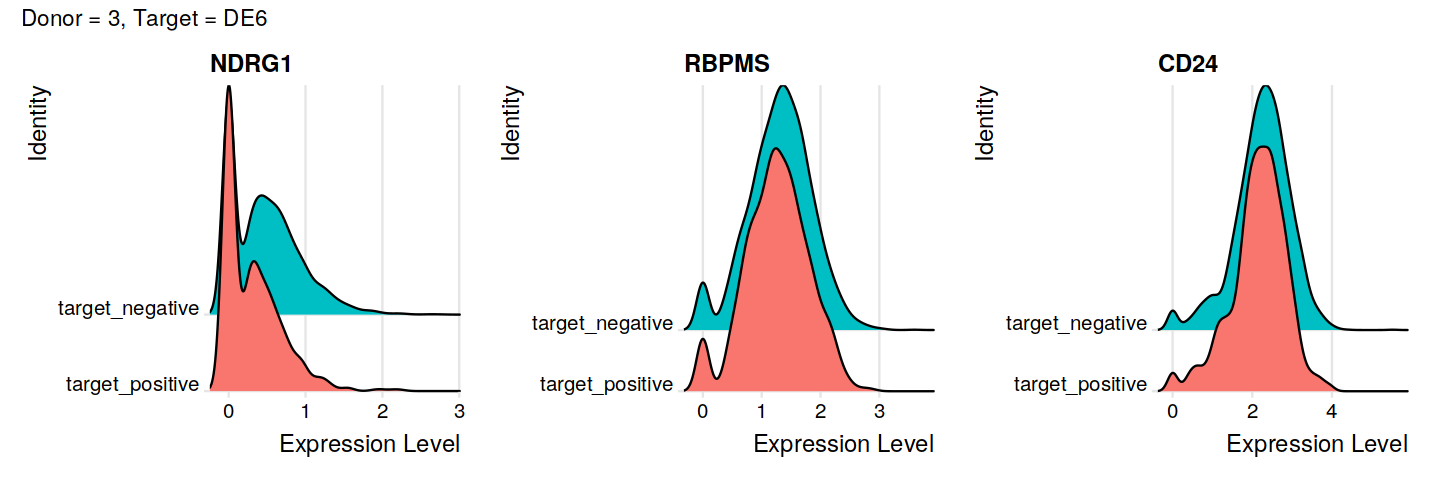

Picking joint bandwidth of 0.0895

Picking joint bandwidth of 0.106

Picking joint bandwidth of 0.133



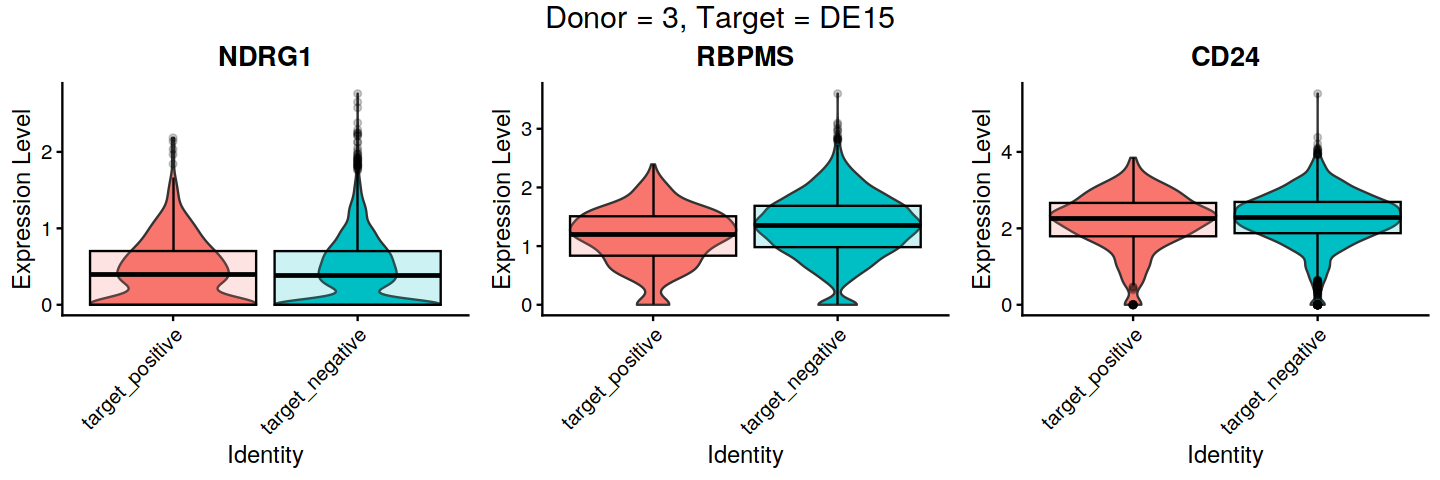

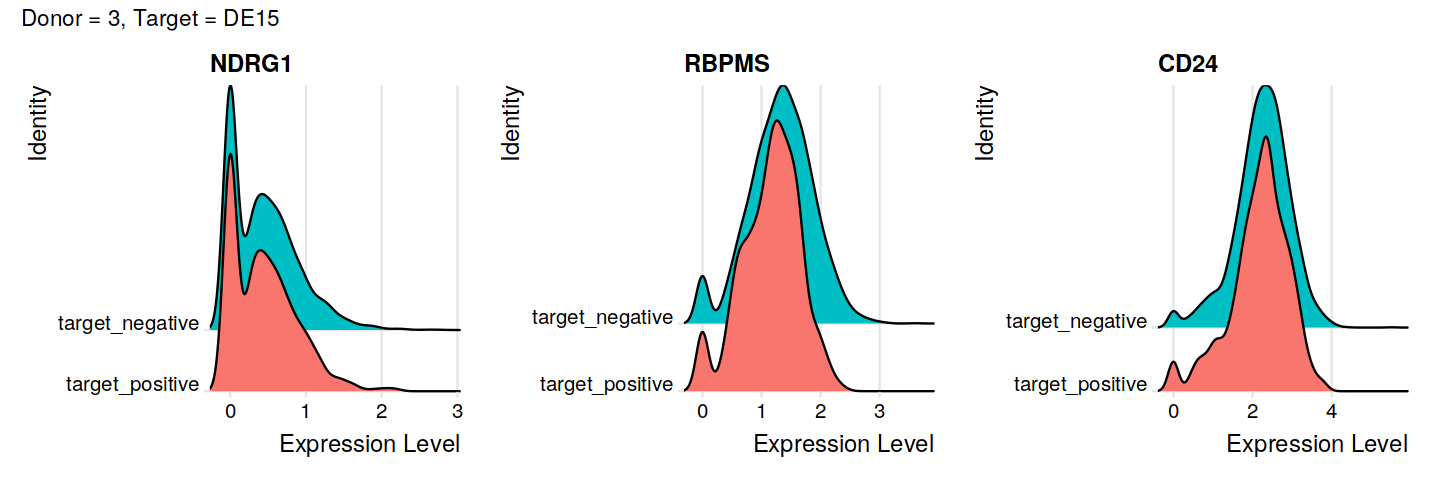

In [23]:
targets = c("DE6", "DE15")
regulated_genes = c("NDRG1", "RBPMS", "CD24")

donors = sort(unique(seurat_rna$donor))

for(donor_id in donors) {
    seurat_donor = subset(seurat_rna, subset = donor == donor_id)
    perturbed_cells_by_guide = get_perturbed_cells(seurat_combined, df_thresholds, donor_id)    

    for(i in seq_along(targets)) {        
        target = targets[i]
        title <- paste0("Donor = ", donor_id, ", Target = ", target)
        print(target)
        guides = get_guides_by_subclass(df_guide, 'alias', target)
        seurat_donor <- mark_target_pos_neg(
            seurat_donor, 
            perturbed_cells_by_guide, 
            guides, 
            print_counts = T
        ) 

        options(repr.plot.width=6, repr.plot.height=4)
        plots <- VlnPlot(
                object = seurat_donor,
                features = regulated_genes, 
                idents = NULL, 
                pt.size = 0, 
                sort = F, 
                ncol = 3,  
                combine = F  
            ) 

        for(i in 1:length(plots)) {
            plots[[i]] <- plots[[i]] + 
            NoLegend() +
            geom_boxplot(width=2, color="black", alpha=0.2)
        }
        plt1 <- ggarrange(plotlist=plots, ncol=3, nrow = 1) 
        plt1 <- annotate_figure(plt1, top = text_grob(title, color = "black", size = 18))  

        options(repr.plot.width=12, repr.plot.height=4)
        plt2 <- RidgePlot(
            object = seurat_donor,
            features = regulated_genes, 
            idents = NULL,  
            sort = F, 
            ncol = 3,    
        ) + plot_annotation(title = title)

        print(plt1) 
        print(plt2)
    }

}

In [24]:
print(df_de %>% filter(donor == donor_id) %>% arrange(p_val_adj) )

        p_val avg_log2FC pct.1 pct.2 p_val_adj     de_gene   target donor
1    2.0e-104      -0.56 1.000 1.000  7.4e-100        FTH1     FTH1     3
2     8.9e-57      -0.83 0.792 0.917   3.2e-52      LGALS3   LGALS3     3
3     3.0e-46      -0.59 0.444 0.793   1.1e-41        NT5E     NT5E     3
4     3.9e-42      -0.65 0.958 0.959   1.4e-37        CTSB     CTSB     3
5     1.2e-35      -0.44 0.925 0.975   4.3e-31         TKT      TKT     3
6     1.2e-30      -0.30 0.277 0.605   4.2e-26    C15orf40 C15orf40     3
7     2.7e-29      -0.31 0.943 0.978   9.7e-25        CSTB     CSTB     3
8     6.1e-27      -0.29 0.681 0.798   2.2e-22       PLIN3    PLIN3     3
9     1.7e-24      -0.49 0.557 0.783   6.4e-20       ANPEP    ANPEP     3
10    3.5e-24       0.33 0.984 0.984   1.3e-19        PSAP     FTH1     3
11    2.9e-20      -0.21 0.131 0.373   1.1e-15        CD55     CD55     3
12    1.6e-19      -0.27 0.564 0.689   6.0e-15       NDRG1      DE6     3
13    4.0e-16       0.19 0.941 0.910  